<a href="https://colab.research.google.com/github/PondKann/CXR-Project/blob/main/DenseNet201_Pretrained_BS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) K-fold อันเดิมที่เปลี่ยนแค่ BS ยังไม่มีการเปลี่ยน loss, optimizer

2) Train-Test มี binary , categorical, RMSprop, Adam ยังไม่มี SGD 


###### import

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
import numpy as np
import pandas as pd
from torchsummary import summary
from skimage.io import imread, imsave
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import PIL
from PIL import Image


In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from imutils import paths
import argparse

from sklearn.model_selection import KFold
from sklearn import metrics
from scipy.stats import zscore


import matplotlib.image as mpimg
from matplotlib.pyplot import savefig

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [ ]:
import pickle
import joblib

######Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = '/content/drive/My Drive/Senior Project/CXR Image3class'

train 3 class

In [ ]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

#### train 3 class  --- สร้างตารางเก็บ ชื่อภาพ และชื่อคลาส
ข้อมูลใน All_3class_dir รวมภาพทั้ง 3 คลาส รวม 451 ภาพ TB150, Normal151 และ CA150 (CA คือ lungcancer)

In [ ]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

In [ ]:
normal = []
for i in range(len(os.listdir(Normal151_dir))):
    img = os.listdir(Normal151_dir)[i]
    normal.append(img)
    
tnormal = pd.DataFrame({'ImageName':[normal][0],
                                       'NameType': "Normal" ,
                                       'NumberType': 0                      })

In [ ]:
tuberculosis = []
for i in range(len(os.listdir(TB150_dir))):
    img = os.listdir(TB150_dir)[i]
    tuberculosis.append(img)

ttuberculosis = pd.DataFrame({'ImageName':[tuberculosis][0],
                                       'NameType': "Tuberculosis" ,
                                       'NumberType': 1                        })

In [ ]:
lungcancer = []
for i in range(len(os.listdir(CA150_dir))):
    img = os.listdir(CA150_dir)[i]
    lungcancer.append(img)

tlungcancer = pd.DataFrame({'ImageName':[lungcancer][0],
                                       'NameType': "Lungcancer" ,
                                       'NumberType': 2                        })

In [ ]:
data_train3 = pd.concat([tnormal, ttuberculosis, tlungcancer])
data_train3[-3:]

,ImageName,NameType,NumberType
147,ca126.jpg,Lungcancer,2
148,ca142.jpg,Lungcancer,2
149,ca146.jpg,Lungcancer,2


####  test 3 class จากเน็ต

In [ ]:
TB700_dir = os.path.join(data_dir,'test_model/Tuberculosis700')
Normal94_dir = os.path.join(data_dir,'test_model/NORMAL94')
CA150_dir = os.path.join(data_dir,'CA150')                  #อันเดิมที่ใช้เทรน

AllTest_2class = os.path.join(data_dir,'test_model/AllTest_2class')

In [ ]:
#สำหรับ test model
normal = []
for i in range(len(os.listdir(Normal94_dir))):
    img = os.listdir(Normal94_dir)[i]
    normal.append(img)
    
tnormal94 = pd.DataFrame({'ImageName':[normal][0],
                                       'NameType': "Normal" ,
                                       'NumberType': 0                      })

In [ ]:
#สำหรับ test model
tb700 = []
for i in range(len(os.listdir(TB700_dir))):
    img = os.listdir(TB700_dir)[i]
    tb700.append(img)

ttb700 = pd.DataFrame({'ImageName':[tb700][0],
                                       'NameType': "Tuberculosis" ,
                                       'NumberType': 1                        })

In [ ]:
#สำหรับ test model ข้อม฿ลเดิม
lungcancer = []
for i in range(len(os.listdir(CA150_dir))):
    img = os.listdir(CA150_dir)[i]
    lungcancer.append(img)

tlungcancer = pd.DataFrame({'ImageName':[lungcancer][0],
                                       'NameType': "Lungcancer" ,
                                       'NumberType': 2                        })

In [ ]:
data_test2 = pd.concat([tnormal94[:30], ttb700[:30], tlungcancer[:10]])

In [ ]:
test_NorTB = []
for ImageName in tqdm(data_test2['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test2
    image_path = AllTest_2class +'/' + ImageName                          # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (299, 299))
    test_NorTB.append(img)

100%|██████████| 70/70 [00:19<00:00,  3.60it/s]


In [ ]:
data_test = np.array(test_NorTB, dtype="float32") / 255.0

labels_test = np.array(data_test2[['NameType']] )        
labels_test.shape = (len(labels_test),) 

le3_Incep = LabelEncoder()                                                                     
labels_test = le3_Incep.fit_transform(labels_test)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_test = to_categorical(labels_test, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

# K-fold -- DenseNet201

## 1) K-fold  -- DenseNet201

### -->ACC = 0.70
### -->เวลา 3859.136 วินาที

*   BS = 8
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS = 8
EPOCHS = 50

aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense = model_Dense.predict(x_test_Dense)
    
    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
45/45 [==============================] - 100s 2s/step - loss: 0.6230 - accuracy: 0.4250 - val_loss: 0.5992 - val_accuracy: 0.4505
Epoch 2/30
45/45 [==============================] - 141s 3s/step - loss: 0.6055 - accuracy: 0.4778 - val_loss: 0.5864 - val_accuracy: 0.4835
Epoch 3/30
45/45 [==============================] - 134s 3s/step - loss: 0.5867 - accuracy: 0.5583 - val_loss: 0.5721 - val_accuracy: 0.5824
Epoch 4/30
45/45 [==============================] - 154s 3s/step - loss: 0.5776 - accuracy: 0.5556 - val_loss: 0.5604 - val_accuracy: 0.6703
Epoch 5/30
45/45 [==============================] - 112s 3s/step - loss: 0.5652 - accuracy: 0.5861 - val_loss: 0.5502 - val_accuracy: 0.6374
Epoch 6/30
45/45 [==============================] - 113s 3s/step - loss: 0.5543 - accuracy: 0.6194 - val_loss: 0.5376 - val_accuracy: 0.7143
Epoch 7/30
45/45 [==============================] - 115s 3s/step - loss: 0.5425 - accuracy: 0.6444 - val_loss: 0.5308 - val_accuracy: 0.6484
Epoch

In [ ]:
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)

In [ ]:
score = metrics.accuracy_score(oos_y.argmax(axis=1),	        #ค่า acc
                                             oos_pred.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.6962305986696231
              precision    recall  f1-score   support

  Lungcancer       0.75      0.55      0.63       150
      Normal       0.67      0.97      0.79       151
Tuberculosis       0.69      0.57      0.63       150

    accuracy                           0.70       451
   macro avg       0.70      0.70      0.68       451
weighted avg       0.70      0.70      0.68       451



## 1.2) K-fold  -- DenseNet201

### -->ACC = 0.70 
### -->เวลา 4918.566 วินาที

*   BS = 8
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:05<00:00, 79.48it/s] 


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS = 8
EPOCHS = 50

aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="sigmoid")(average_pooling_layer)   # unit 3
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense = model_Dense.predict(x_test_Dense)
    
    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
45/45 [==============================] - 152s 3s/step - loss: 0.6307 - accuracy: 0.4639 - val_loss: 0.5992 - val_accuracy: 0.5055
Epoch 2/30
45/45 [==============================] - 141s 3s/step - loss: 0.5935 - accuracy: 0.5333 - val_loss: 0.5830 - val_accuracy: 0.5275
Epoch 3/30
45/45 [==============================] - 105s 2s/step - loss: 0.5795 - accuracy: 0.5639 - val_loss: 0.5690 - val_accuracy: 0.5714
Epoch 4/30
45/45 [==============================] - 105s 2s/step - loss: 0.5651 - accuracy: 0.6083 - val_loss: 0.5597 - val_accuracy: 0.5714
Epoch 5/30
45/45 [==============================] - 105s 2s/step - loss: 0.5481 - accuracy: 0.6333 - val_loss: 0.5485 - val_accuracy: 0.5714
Epoch 6/30
45/45 [==============================] - 105s 2s/step - loss: 0.5472 - accuracy: 0.6222 - val_loss: 0.5421 - val_accuracy: 0.5714
              precision    recall  f1-score   support

  Lungcancer       0.55      0.39      0.46        28
      Normal       0.62      1.00    

In [ ]:
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)

In [ ]:
score = metrics.accuracy_score(oos_y.argmax(axis=1),	        #ค่า acc
                                             oos_pred.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.6962305986696231
              precision    recall  f1-score   support

  Lungcancer       0.77      0.61      0.68       150
      Normal       0.66      0.98      0.79       151
Tuberculosis       0.69      0.49      0.57       150

    accuracy                           0.70       451
   macro avg       0.71      0.70      0.68       451
weighted avg       0.71      0.70      0.68       451



## 2) K-fold  -- DenseNet201

### -->ACC = 0.65
### -->เวลา 34 นาที

*   BS = 16
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:04<00:00, 92.91it/s] 


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS16 = 16
EPOCHS = 50

aug2 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense2 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense2 = KFold(5, shuffle=True, random_state=40) 

oos_y2 = []
oos_pred2 = []
fold = 0

for train, test in kf_Dense2.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense2 = data_Dense[train]
    y_train_Dense2 = labels_Dense[train]
    x_test_Dense2 = data_Dense[test]
    y_test_Dense2 = labels_Dense[test]

    H_Dense2 = model_Dense2.fit( x=aug2.flow(x_train_Dense2, y_train_Dense2, batch_size=BS16),
	                                            validation_data=(x_test_Dense2, y_test_Dense2),
	                                            steps_per_epoch=len(x_train_Dense2) // BS16,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense2 = model_Dense2.predict(x_test_Dense2)
    
    oos_y2.append(y_test_Dense2)
    oos_pred2.append(pred_Dense2)  
    print(classification_report(y_test_Dense2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense2.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
22/22 [==============================] - 109s 4s/step - loss: 0.6742 - accuracy: 0.3837 - val_loss: 0.6225 - val_accuracy: 0.5495
Epoch 2/30
22/22 [==============================] - 98s 5s/step - loss: 0.6248 - accuracy: 0.4506 - val_loss: 0.6098 - val_accuracy: 0.5714
Epoch 3/30
22/22 [==============================] - 98s 4s/step - loss: 0.6055 - accuracy: 0.4971 - val_loss: 0.5992 - val_accuracy: 0.5824
Epoch 4/30
22/22 [==============================] - 103s 5s/step - loss: 0.6024 - accuracy: 0.5436 - val_loss: 0.5895 - val_accuracy: 0.6264
Epoch 5/30
22/22 [==============================] - 100s 5s/step - loss: 0.5971 - accuracy: 0.5116 - val_loss: 0.5807 - val_accuracy: 0.6374
Epoch 6/30
22/22 [==============================] - 99s 5s/step - loss: 0.5824 - accuracy: 0.5785 - val_loss: 0.5746 - val_accuracy: 0.6154
Epoch 7/30
22/22 [==============================] - 100s 5s/step - loss: 0.5668 - accuracy: 0.6192 - val_loss: 0.5659 - val_accuracy: 0.6593
Epoch 8/

In [ ]:
oos_y2 = np.concatenate(oos_y2)
oos_pred2 = np.concatenate(oos_pred2)

In [ ]:
score = metrics.accuracy_score(oos_y2.argmax(axis=1),	        #ค่า acc
                                             oos_pred2.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred2.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.6541019955654102
              precision    recall  f1-score   support

  Lungcancer       0.80      0.52      0.63       150
      Normal       0.61      0.97      0.75       151
Tuberculosis       0.63      0.47      0.54       150

    accuracy                           0.65       451
   macro avg       0.68      0.65      0.64       451
weighted avg       0.68      0.65      0.64       451



## 2.1) K-fold  -- DenseNet201

### -->ACC = 0.69
### -->เวลา 5093.751 นาที

*   BS = 16
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [02:08<00:00,  3.51it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS16 = 16
EPOCHS = 50

aug21 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="sigmoid")(average_pooling_layer)   # unit 3
model_Dense21 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense21.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

74850304/74836368 [==============================] - 2s 0us/step


In [ ]:
kf_Dense21 = KFold(5, shuffle=True, random_state=40) 

oos_y21 = []
oos_pred21 = []
fold = 0

for train, test in kf_Dense21.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense21 = data_Dense[train]
    y_train_Dense21 = labels_Dense[train]
    x_test_Dense21 = data_Dense[test]
    y_test_Dense21 = labels_Dense[test]

    H_Dense21 = model_Dense21.fit( x=aug21.flow(x_train_Dense21, y_train_Dense21, batch_size=BS16),
	                                            validation_data=(x_test_Dense21, y_test_Dense21),
	                                            steps_per_epoch=len(x_train_Dense21) // BS16,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense21 = model_Dense21.predict(x_test_Dense21)
    
    oos_y21.append(y_test_Dense21)
    oos_pred21.append(pred_Dense21)  
    print(classification_report(y_test_Dense21.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense21.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
22/22 [==============================] - 104s 4s/step - loss: 0.6511 - accuracy: 0.4157 - val_loss: 0.6298 - val_accuracy: 0.4066
Epoch 2/30
22/22 [==============================] - 89s 4s/step - loss: 0.6400 - accuracy: 0.3866 - val_loss: 0.6223 - val_accuracy: 0.4396
Epoch 3/30
22/22 [==============================] - 89s 4s/step - loss: 0.6278 - accuracy: 0.4273 - val_loss: 0.6128 - val_accuracy: 0.5055
Epoch 4/30
22/22 [==============================] - 88s 4s/step - loss: 0.6184 - accuracy: 0.4651 - val_loss: 0.6035 - val_accuracy: 0.5385
Epoch 5/30
22/22 [==============================] - 89s 4s/step - loss: 0.6068 - accuracy: 0.5087 - val_loss: 0.5941 - val_accuracy: 0.5824
Epoch 6/30
22/22 [==============================] - 88s 4s/step - loss: 0.5986 - accuracy: 0.5233 - val_loss: 0.5856 - val_accuracy: 0.6154
Epoch 7/30
22/22 [==============================] - 89s 4s/step - loss: 0.5862 - accuracy: 0.5552 - val_loss: 0.5780 - val_accuracy: 0.6703
Epoch 8/30


In [ ]:
oos_y21 = np.concatenate(oos_y21)
oos_pred21 = np.concatenate(oos_pred21)

In [ ]:
score = metrics.accuracy_score(oos_y21.argmax(axis=1),	        #ค่า acc
                                             oos_pred21.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y21.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred21.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.6940133037694013
              precision    recall  f1-score   support

  Lungcancer       0.75      0.65      0.70       150
      Normal       0.64      0.99      0.78       151
Tuberculosis       0.74      0.44      0.55       150

    accuracy                           0.69       451
   macro avg       0.71      0.69      0.68       451
weighted avg       0.71      0.69      0.68       451



## 3) K-fold  -- DenseNet201

### -->ACC = 0.65 
### -->เวลา 5419.91 วินาที

*   BS = 32
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:05<00:00, 83.88it/s] 


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS32 = 32
EPOCHS = 50

aug3 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense3 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense3 = KFold(5, shuffle=True, random_state=40) 

oos_y3 = []
oos_pred3 = []
fold = 0

for train, test in kf_Dense3.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense3 = data_Dense[train]
    y_train_Dense3 = labels_Dense[train]
    x_test_Dense3 = data_Dense[test]
    y_test_Dense3 = labels_Dense[test]

    H_Dense3 = model_Dense3.fit( x=aug3.flow(x_train_Dense3, y_train_Dense3, batch_size=BS32),
	                                            validation_data=(x_test_Dense3, y_test_Dense3),
	                                            steps_per_epoch=len(x_train_Dense3) // BS32,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense3 = model_Dense3.predict(x_test_Dense3)
    
    oos_y3.append(y_test_Dense3)
    oos_pred3.append(pred_Dense3)  
    print(classification_report(y_test_Dense3.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense3.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
11/11 [==============================] - 97s 8s/step - loss: 0.7570 - accuracy: 0.2896 - val_loss: 0.6820 - val_accuracy: 0.3407
Epoch 2/30
11/11 [==============================] - 82s 8s/step - loss: 0.6755 - accuracy: 0.3293 - val_loss: 0.6577 - val_accuracy: 0.3846
Epoch 3/30
11/11 [==============================] - 82s 8s/step - loss: 0.6624 - accuracy: 0.3110 - val_loss: 0.6504 - val_accuracy: 0.3626
Epoch 4/30
11/11 [==============================] - 82s 8s/step - loss: 0.6525 - accuracy: 0.3537 - val_loss: 0.6447 - val_accuracy: 0.3516
Epoch 5/30
11/11 [==============================] - 82s 8s/step - loss: 0.6519 - accuracy: 0.3445 - val_loss: 0.6387 - val_accuracy: 0.3956
Epoch 6/30
11/11 [==============================] - 86s 8s/step - loss: 0.6336 - accuracy: 0.4119 - val_loss: 0.6321 - val_accuracy: 0.3956
Epoch 7/30
11/11 [==============================] - 82s 8s/step - loss: 0.6294 - accuracy: 0.3750 - val_loss: 0.6255 - val_accuracy: 0.4505
Epoch 8/30
1

In [ ]:
oos_y3 = np.concatenate(oos_y3)
oos_pred3 = np.concatenate(oos_pred3)

In [ ]:
score = metrics.accuracy_score(oos_y3.argmax(axis=1),	        #ค่า acc
                                             oos_pred3.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y3.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred3.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.6541019955654102
              precision    recall  f1-score   support

  Lungcancer       0.80      0.48      0.60       150
      Normal       0.63      0.87      0.73       151
Tuberculosis       0.60      0.61      0.61       150

    accuracy                           0.65       451
   macro avg       0.68      0.65      0.65       451
weighted avg       0.68      0.65      0.65       451



## 3.1) K-fold  -- DenseNet201  ก็อปไปใส่ไฟล์ DenseNet201_pretrained_bs แล้ว

### -->ACC = 0.65 
### -->เวลา 5985.206 วินาที

*   BS = 32
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:04<00:00, 93.45it/s] 


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS32 = 32
EPOCHS = 50

aug31 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="sigmoid")(average_pooling_layer)   # unit 3
model_Dense31 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense31.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense31 = KFold(5, shuffle=True, random_state=40) 

oos_y31 = []
oos_pred31 = []
fold = 0

for train, test in kf_Dense31.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense31 = data_Dense[train]
    y_train_Dense31 = labels_Dense[train]
    x_test_Dense31 = data_Dense[test]
    y_test_Dense31 = labels_Dense[test]

    H_Dense31 = model_Dense31.fit( x=aug31.flow(x_train_Dense31, y_train_Dense31, batch_size=BS32),
	                                            validation_data=(x_test_Dense31, y_test_Dense31),
	                                            steps_per_epoch=len(x_train_Dense31) // BS32,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense31 = model_Dense31.predict(x_test_Dense31)
    
    oos_y31.append(y_test_Dense31)
    oos_pred31.append(pred_Dense31)  
    print(classification_report(y_test_Dense31.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense31.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
11/11 [==============================] - 99s 8s/step - loss: 0.7409 - accuracy: 0.3018 - val_loss: 0.7162 - val_accuracy: 0.2527
Epoch 2/30
11/11 [==============================] - 86s 8s/step - loss: 0.6801 - accuracy: 0.2988 - val_loss: 0.6940 - val_accuracy: 0.2747
Epoch 3/30
11/11 [==============================] - 85s 8s/step - loss: 0.6637 - accuracy: 0.2805 - val_loss: 0.6833 - val_accuracy: 0.2967
Epoch 4/30
11/11 [==============================] - 85s 8s/step - loss: 0.6521 - accuracy: 0.3262 - val_loss: 0.6761 - val_accuracy: 0.3187
Epoch 5/30
11/11 [==============================] - 85s 8s/step - loss: 0.6464 - accuracy: 0.3354 - val_loss: 0.6698 - val_accuracy: 0.3297
Epoch 6/30
11/11 [==============================] - 89s 9s/step - loss: 0.6323 - accuracy: 0.4299 - val_loss: 0.6630 - val_accuracy: 0.3297
Epoch 7/30
11/11 [==============================] - 88s 8s/step - loss: 0.6264 - accuracy: 0.4360 - val_loss: 0.6552 - val_accuracy: 0.4176
Epoch 8/30
1

In [ ]:
oos_y31 = np.concatenate(oos_y31)
oos_pred31 = np.concatenate(oos_pred31)

In [ ]:
score = metrics.accuracy_score(oos_y31.argmax(axis=1),	        #ค่า acc
                                             oos_pred31.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y31.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred31.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.647450110864745
              precision    recall  f1-score   support

  Lungcancer       0.75      0.52      0.61       150
      Normal       0.62      0.98      0.76       151
Tuberculosis       0.62      0.44      0.51       150

    accuracy                           0.65       451
   macro avg       0.66      0.65      0.63       451
weighted avg       0.66      0.65      0.63       451



## 4) K-fold  -- DenseNet201 

### -->ACC = 0.72
### -->เวลา 4859 วินาที

*   BS = 1
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [02:08<00:00,  3.51it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS = 1
EPOCHS = 50

aug4 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense4 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense4.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
kf_Dense4 = KFold(5, shuffle=True, random_state=40) 

oos_y4 = []
oos_pred4 = []
fold = 0

for train, test in kf_Dense4.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense4 = data_Dense[train]
    y_train_Dense4 = labels_Dense[train]
    x_test_Dense4 = data_Dense[test]
    y_test_Dense4 = labels_Dense[test]

    H_Dense4 = model_Dense4.fit( x=aug4.flow(x_train_Dense4, y_train_Dense4, batch_size=BS),
	                                            validation_data=(x_test_Dense4, y_test_Dense4),
	                                            steps_per_epoch=len(x_train_Dense4) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense4 = model_Dense4.predict(x_test_Dense4)
    
    oos_y4.append(y_test_Dense4)
    oos_pred4.append(pred_Dense4)  
    print(classification_report(y_test_Dense4.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense4.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
360/360 [==============================] - 119s 301ms/step - loss: 0.6247 - accuracy: 0.4861 - val_loss: 0.5918 - val_accuracy: 0.6374
Epoch 2/30
360/360 [==============================] - 113s 313ms/step - loss: 0.5784 - accuracy: 0.5861 - val_loss: 0.5540 - val_accuracy: 0.6264
Epoch 3/30
360/360 [==============================] - 171s 474ms/step - loss: 0.5459 - accuracy: 0.6139 - val_loss: 0.5396 - val_accuracy: 0.6264
Epoch 4/30
360/360 [==============================] - 192s 534ms/step - loss: 0.5245 - accuracy: 0.6639 - val_loss: 0.5129 - val_accuracy: 0.6264
              precision    recall  f1-score   support

  Lungcancer       0.58      0.68      0.62        28
      Normal       0.65      0.97      0.78        33
Tuberculosis       0.67      0.20      0.31        30

    accuracy                           0.63        91
   macro avg       0.63      0.62      0.57        91
weighted avg       0.63      0.63      0.58        91

Fold #2
Epoch 1/30
361/361 

In [ ]:
oos_y4 = np.concatenate(oos_y4)
oos_pred4 = np.concatenate(oos_pred4)

In [ ]:
score = metrics.accuracy_score(oos_y4.argmax(axis=1),	        #ค่า acc
                                             oos_pred4.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y4.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred4.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.7161862527716186
              precision    recall  f1-score   support

  Lungcancer       0.71      0.73      0.72       150
      Normal       0.69      0.98      0.81       151
Tuberculosis       0.78      0.44      0.56       150

    accuracy                           0.72       451
   macro avg       0.73      0.72      0.70       451
weighted avg       0.73      0.72      0.70       451



## 4.1) K-fold  -- DenseNet201  

### -->ACC = 0.71
### -->เวลา 3232.937 วินาที หรือ 53 นาที

*   BS = 1
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:04<00:00, 94.46it/s] 


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS = 1
EPOCHS = 50

aug41 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="sigmoid")(average_pooling_layer)   # unit 3
model_Dense41 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense41.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense41 = KFold(5, shuffle=True, random_state=40) 

oos_y41 = []
oos_pred41 = []
fold = 0

for train, test in kf_Dense41.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense41 = data_Dense[train]
    y_train_Dense41 = labels_Dense[train]
    x_test_Dense41 = data_Dense[test]
    y_test_Dense41 = labels_Dense[test]

    H_Dense41 = model_Dense41.fit( x=aug41.flow(x_train_Dense41, y_train_Dense41, batch_size=BS),
	                                            validation_data=(x_test_Dense41, y_test_Dense41),
	                                            steps_per_epoch=len(x_train_Dense41) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense41 = model_Dense41.predict(x_test_Dense41)
    
    oos_y41.append(y_test_Dense41)
    oos_pred41.append(pred_Dense41)  
    print(classification_report(y_test_Dense41.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense41.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
360/360 [==============================] - 124s 317ms/step - loss: 0.6712 - accuracy: 0.3111 - val_loss: 0.6311 - val_accuracy: 0.4176
Epoch 2/30
360/360 [==============================] - 136s 377ms/step - loss: 0.6247 - accuracy: 0.4306 - val_loss: 0.5933 - val_accuracy: 0.5385
Epoch 3/30
360/360 [==============================] - 137s 381ms/step - loss: 0.5871 - accuracy: 0.5389 - val_loss: 0.5626 - val_accuracy: 0.6484
Epoch 4/30
360/360 [==============================] - 125s 348ms/step - loss: 0.5525 - accuracy: 0.5917 - val_loss: 0.5368 - val_accuracy: 0.6484
Epoch 5/30
360/360 [==============================] - 114s 317ms/step - loss: 0.5319 - accuracy: 0.6472 - val_loss: 0.5142 - val_accuracy: 0.6484
Epoch 6/30
360/360 [==============================] - 118s 329ms/step - loss: 0.5138 - accuracy: 0.6722 - val_loss: 0.4983 - val_accuracy: 0.6484
              precision    recall  f1-score   support

  Lungcancer       0.59      0.36      0.44        28
      N

In [ ]:
oos_y41 = np.concatenate(oos_y41)
oos_pred41 = np.concatenate(oos_pred41)

In [ ]:
score = metrics.accuracy_score(oos_y41.argmax(axis=1),	        #ค่า acc
                                             oos_pred41.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y41.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred41.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.70509977827051
              precision    recall  f1-score   support

  Lungcancer       0.75      0.59      0.66       150
      Normal       0.70      0.98      0.82       151
Tuberculosis       0.68      0.54      0.60       150

    accuracy                           0.71       451
   macro avg       0.71      0.70      0.69       451
weighted avg       0.71      0.71      0.69       451



# Train-Test  รันครบแล้ว
ตรวจสอบดีแล้ว

### 8 ครบ
- binary_crossentropy
- categorical_crossentropy
- RMSprop 
- Adam
- ModelCheckpoint():
ใช้ในการทำ Save Model ที่ดีที่สุดในทุกรอบของการ Modeling
นามสกุลก็จะเป็น .5df เฉพาะ Packages Keras เท่านั้น
- ReduceLROnPlateau(): ใช้ในการลด Learning Rate (ความเร็วในการค้นหาจุดไหนคือ Global Minima)
    - monitor= ’val_loss’: ใช้ Criteria อะไรในการลด Learning Rate
    - patience= 5: ทนรอได้กี่ epoch ก่อนที่จะทำการลดค่า learning rate
    - verbose= 2: รูปแบบการแสดงผลหากเกิด Effect
    - factor= 0.5: หากไม่สามารถลด loss ได้ใน 5 epoch ทำการลด learning rate 50%

#### 8  soft pre bi
--> 0.67

In [ ]:
BS = 8                                                      ##
filepath = "model8_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:10<00:00, 43.27it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H8_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
##
pred_H8_soft_pre_bi = model_Dense.predict(x_test_Dense)
    

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)       

74850304/74836368 [==============================] - 2s 0us/step
Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.7116 - accuracy: 0.3304
Epoch 1: val_accuracy improved from -inf to 0.30088, saving model to model8_soft_pre_bi.h5
42/42 [==============================] - 43s 429ms/step - loss: 0.7116 - accuracy: 0.3304 - val_loss: 0.6715 - val_accuracy: 0.3009 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.6587 - accuracy: 0.3273
Epoch 2: val_accuracy improved from 0.30088 to 0.36283, saving model to model8_soft_pre_bi.h5
42/42 [==============================] - 10s 250ms/step - loss: 0.6587 - accuracy: 0.3273 - val_loss: 0.6477 - val_accuracy: 0.3628 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.6372 - accuracy: 0.3939
Epoch 3: val_accuracy improved from 0.36283 to 0.38053, saving model to model8_soft_pre_bi.h5
42/42 [==============================] - 9s 205ms/step - loss: 0.6372 - a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
cf.go_offline()

print(H_Dense.history.keys())

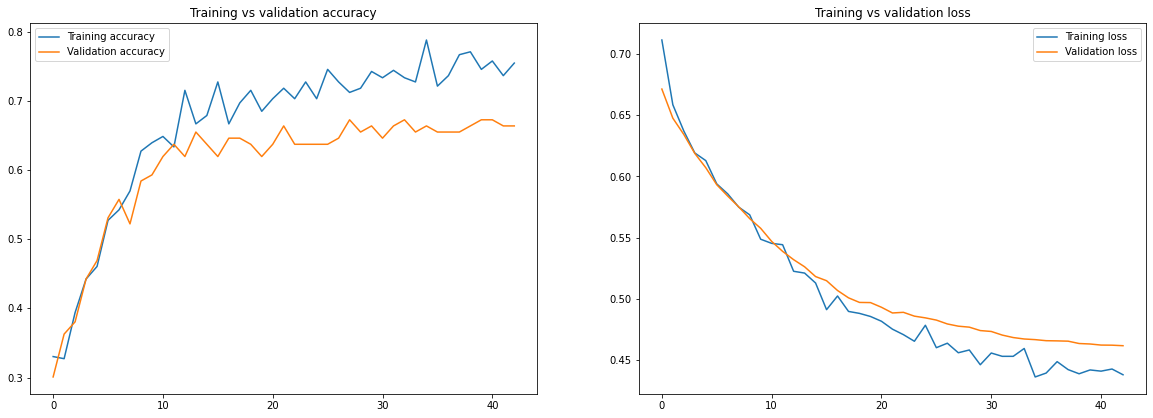

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H8_soft_pre_bi                            ##
pred_Dense = pred_H8_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[21  5  9]
 [ 0 41  0]
 [10 14 13]]
Normalized confusion matrix
[[0.6  0.14 0.26]
 [0.   1.   0.  ]
 [0.27 0.38 0.35]]


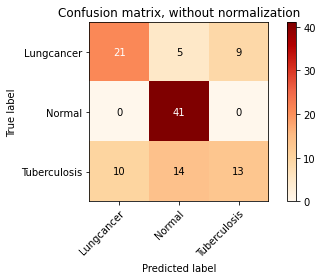

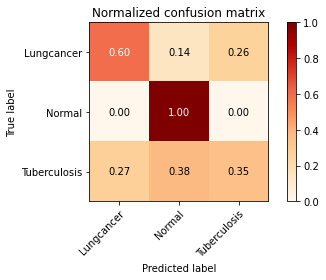

In [ ]:
y_pred = pred_H8_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 soft pre bi adam  
--> 0.64

In [ ]:
BS = 8                                                           ##
filepath = "model8_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 93.76it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H8_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H8_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_bi_adam.argmax(axis=1),               ####
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.2576
Epoch 1: val_accuracy improved from -inf to 0.24779, saving model to model8_soft_pre_bi_adam.h5
42/42 [==============================] - 24s 289ms/step - loss: 0.6888 - accuracy: 0.2576 - val_loss: 0.6702 - val_accuracy: 0.2478 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 0.2636
Epoch 2: val_accuracy improved from 0.24779 to 0.28319, saving model to model8_soft_pre_bi_adam.h5
42/42 [==============================] - 9s 207ms/step - loss: 0.6680 - accuracy: 0.2636 - val_loss: 0.6566 - val_accuracy: 0.2832 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.6500 - accuracy: 0.3273
Epoch 3: val_accuracy improved from 0.28319 to 0.31858, saving model to model8_soft_pre_bi_adam.h5
42/42 [==============================] - 9s 206ms/step - loss: 0.6500 - accuracy: 0.3273 - val_loss: 0.6434 - val_accuracy: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

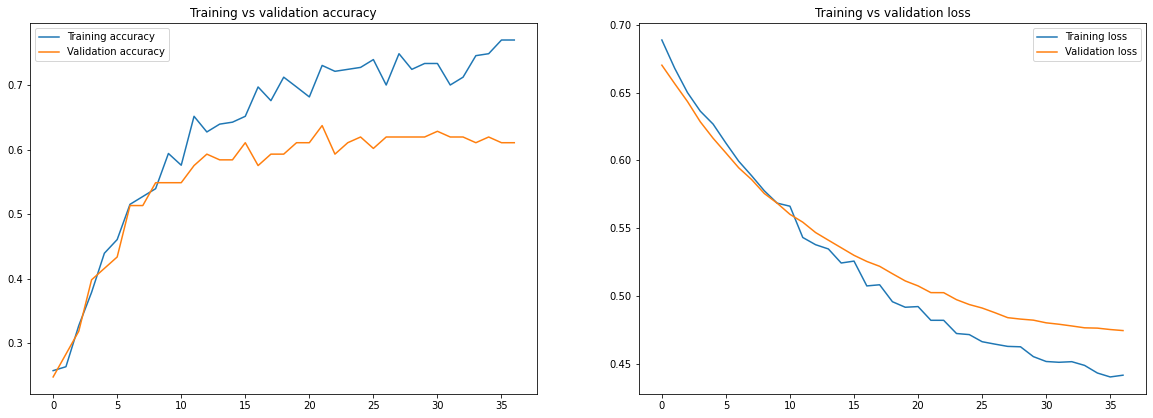

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H8_soft_pre_bi_adam                            ##
pred_Dense = pred_H8_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[16  6 13]
 [ 0 39  2]
 [10 13 14]]
Normalized confusion matrix
[[0.46 0.17 0.37]
 [0.   0.95 0.05]
 [0.27 0.35 0.38]]


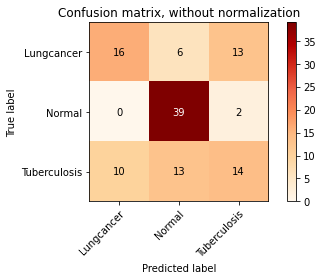

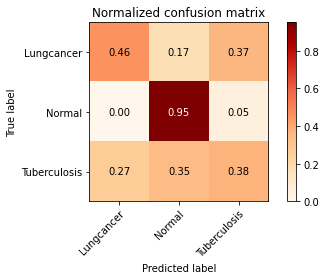

In [ ]:
y_pred = pred_H8_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#### 8 soft pre cate 
--> 0.72

In [ ]:
BS = 8                                                             ##
filepath = "model8_soft_pre_cate.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 94.44it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H8_soft_pre_cate = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H8_soft_pre_cate = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_cate.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 1.1716 - accuracy: 0.3455
Epoch 1: val_accuracy improved from -inf to 0.44248, saving model to model8_soft_pre_cate.h5
42/42 [==============================] - 24s 288ms/step - loss: 1.1716 - accuracy: 0.3455 - val_loss: 1.0562 - val_accuracy: 0.4425 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 1.0827 - accuracy: 0.3606
Epoch 2: val_accuracy improved from 0.44248 to 0.48673, saving model to model8_soft_pre_cate.h5
42/42 [==============================] - 9s 202ms/step - loss: 1.0827 - accuracy: 0.3606 - val_loss: 1.0186 - val_accuracy: 0.4867 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 1.0661 - accuracy: 0.4121
Epoch 3: val_accuracy improved from 0.48673 to 0.53097, saving model to model8_soft_pre_cate.h5
42/42 [==============================] - 8s 201ms/step - loss: 1.0661 - accuracy: 0.4121 - val_loss: 0.9855 - val_accuracy: 0.5310 - 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

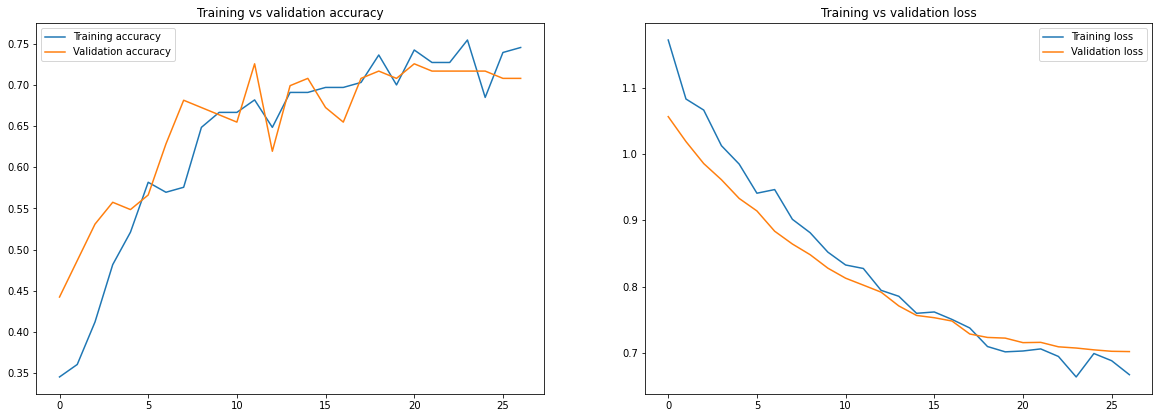

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H8_soft_pre_cate                            ##
pred_Dense = pred_H8_soft_pre_cate                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[19  4 12]
 [ 0 39  2]
 [ 4 11 22]]
Normalized confusion matrix
[[0.54 0.11 0.34]
 [0.   0.95 0.05]
 [0.11 0.3  0.59]]


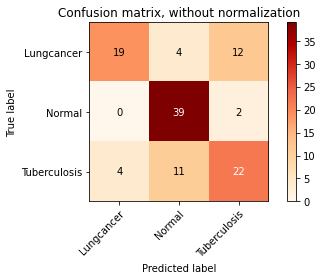

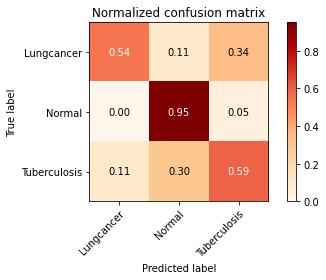

In [ ]:
y_pred = pred_H8_soft_pre_cate.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 soft pre cate adam
--> 0.71

In [ ]:
BS = 8                                                       ##
filepath = "model8_soft_pre_cate_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 97.31it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H8_soft_pre_cate_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H8_soft_pre_cate_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_cate_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 1.1990 - accuracy: 0.3333
Epoch 1: val_accuracy improved from -inf to 0.24779, saving model to model8_soft_pre_cate_adam.h5
42/42 [==============================] - 23s 283ms/step - loss: 1.1990 - accuracy: 0.3333 - val_loss: 1.2003 - val_accuracy: 0.2478 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 1.1564 - accuracy: 0.3182
Epoch 2: val_accuracy improved from 0.24779 to 0.27434, saving model to model8_soft_pre_cate_adam.h5
42/42 [==============================] - 9s 204ms/step - loss: 1.1564 - accuracy: 0.3182 - val_loss: 1.1683 - val_accuracy: 0.2743 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 1.1079 - accuracy: 0.3788
Epoch 3: val_accuracy improved from 0.27434 to 0.30088, saving model to model8_soft_pre_cate_adam.h5
42/42 [==============================] - 9s 212ms/step - loss: 1.1079 - accuracy: 0.3788 - val_loss: 1.1219 - val_accu

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

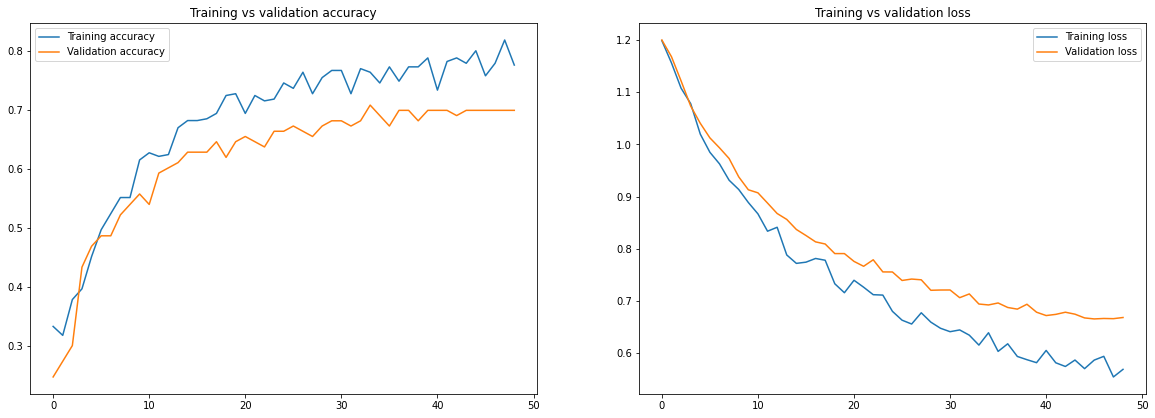

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H8_soft_pre_cate_adam                            ##
pred_Dense = pred_H8_soft_pre_cate_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[25  4  6]
 [ 2 39  0]
 [11 11 15]]
Normalized confusion matrix
[[0.71 0.11 0.17]
 [0.05 0.95 0.  ]
 [0.3  0.3  0.41]]


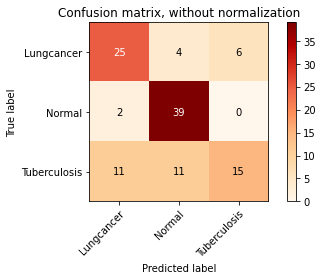

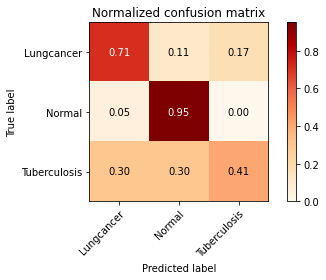

In [ ]:
y_pred = pred_H8_soft_pre_cate_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 16  


#### 16  soft pre bi
--> 0.69

In [ ]:
BS = 16                                                       ##
filepath = "model16_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 93.80it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H16_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])

pred_H16_soft_pre_bi = model_Dense.predict(x_test_Dense)
    
	
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)       

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.6980 - accuracy: 0.3975
Epoch 1: val_accuracy improved from -inf to 0.36283, saving model to model16_soft_pre_bi.h5
21/21 [==============================] - 26s 591ms/step - loss: 0.6980 - accuracy: 0.3975 - val_loss: 0.6458 - val_accuracy: 0.3628 - lr: 1.0000e-04
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.6331 - accuracy: 0.4317
Epoch 2: val_accuracy improved from 0.36283 to 0.37168, saving model to model16_soft_pre_bi.h5
21/21 [==============================] - 8s 387ms/step - loss: 0.6331 - accuracy: 0.4317 - val_loss: 0.6255 - val_accuracy: 0.3717 - lr: 1.0000e-04
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.6232 - accuracy: 0.4627
Epoch 3: val_accuracy improved from 0.37168 to 0.38053, saving model to model16_soft_pre_bi.h5
21/21 [==============================] - 8s 388ms/step - loss: 0.6232 - accuracy: 0.4627 - val_loss: 0.6162 - val_accuracy: 0.3805 - lr:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

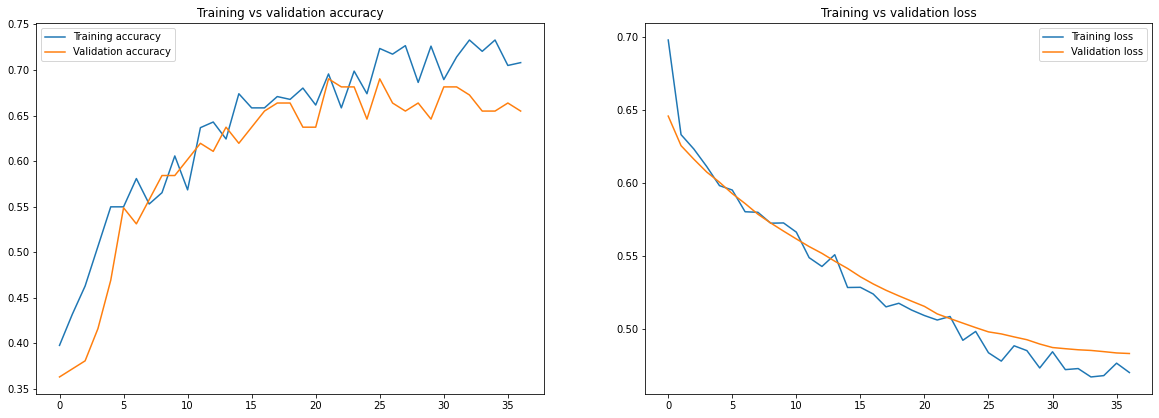

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H16_soft_pre_bi                            ##
pred_Dense = pred_H16_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[17  8 10]
 [ 0 38  3]
 [ 6 12 19]]
Normalized confusion matrix
[[0.49 0.23 0.29]
 [0.   0.93 0.07]
 [0.16 0.32 0.51]]


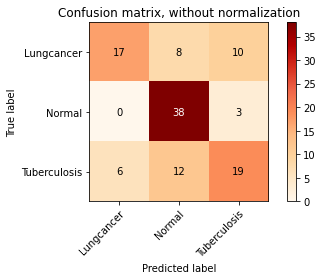

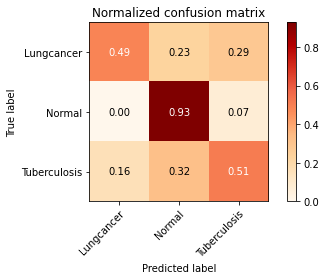

In [ ]:
y_pred = pred_H16_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 soft pre bi adam
--> 0.64

In [ ]:
BS = 16                                                       ##
filepath = "model16_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 94.87it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H16_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H16_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_bi_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.8036 - accuracy: 0.2671
Epoch 1: val_accuracy improved from -inf to 0.33628, saving model to model16_soft_pre_bi_adam.h5
21/21 [==============================] - 24s 586ms/step - loss: 0.8036 - accuracy: 0.2671 - val_loss: 0.6928 - val_accuracy: 0.3363 - lr: 1.0000e-04
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.6973 - accuracy: 0.2981
Epoch 2: val_accuracy did not improve from 0.33628
21/21 [==============================] - 6s 289ms/step - loss: 0.6973 - accuracy: 0.2981 - val_loss: 0.6490 - val_accuracy: 0.3363 - lr: 1.0000e-04
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.6583 - accuracy: 0.3416
Epoch 3: val_accuracy improved from 0.33628 to 0.41593, saving model to model16_soft_pre_bi_adam.h5
21/21 [==============================] - 8s 372ms/step - loss: 0.6583 - accuracy: 0.3416 - val_loss: 0.6343 - val_accuracy: 0.4159 - lr: 1.0000e-04
Epoch 4/100
21/21 [===

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

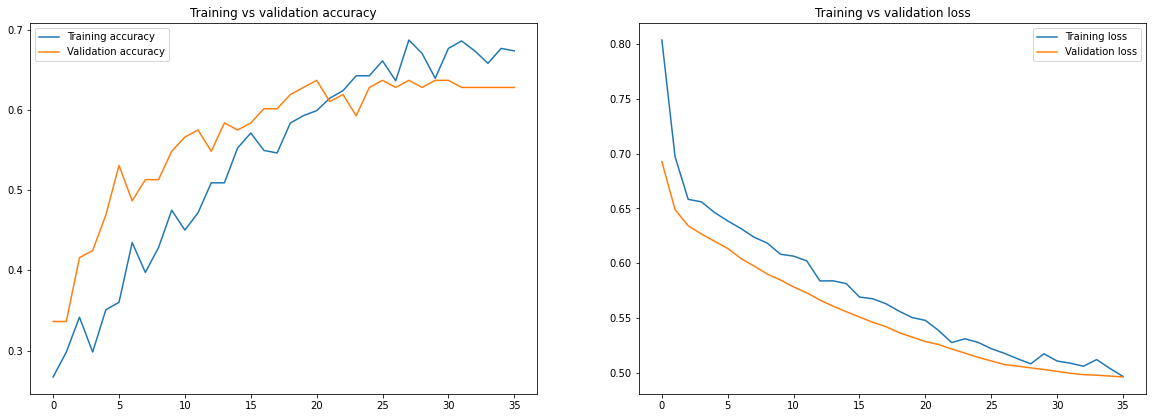

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H16_soft_pre_bi_adam                            ##
pred_Dense = pred_H16_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[15  5 15]
 [ 1 37  3]
 [ 8 10 19]]
Normalized confusion matrix
[[0.43 0.14 0.43]
 [0.02 0.9  0.07]
 [0.22 0.27 0.51]]


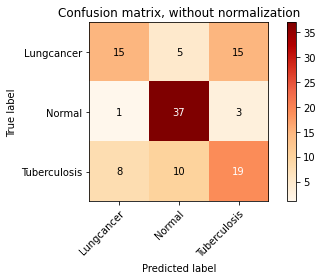

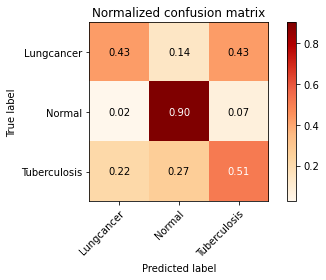

In [ ]:
y_pred = pred_H16_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 soft pre cate 
--> 0.69

In [ ]:
BS = 16                                                       ##
filepath = "model16_soft_pre_cate.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 96.45it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H16_soft_pre_cate = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H16_soft_pre_cate = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_cate.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 1.2538 - accuracy: 0.3416
Epoch 1: val_accuracy improved from -inf to 0.32743, saving model to model16_soft_pre_cate.h5
21/21 [==============================] - 23s 543ms/step - loss: 1.2538 - accuracy: 0.3416 - val_loss: 1.2093 - val_accuracy: 0.3274 - lr: 1.0000e-04
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 1.1381 - accuracy: 0.3540
Epoch 2: val_accuracy improved from 0.32743 to 0.35398, saving model to model16_soft_pre_cate.h5
21/21 [==============================] - 9s 422ms/step - loss: 1.1381 - accuracy: 0.3540 - val_loss: 1.1411 - val_accuracy: 0.3540 - lr: 1.0000e-04
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 1.1065 - accuracy: 0.3944
Epoch 3: val_accuracy improved from 0.35398 to 0.38938, saving model to model16_soft_pre_cate.h5
21/21 [==============================] - 8s 374ms/step - loss: 1.1065 - accuracy: 0.3944 - val_loss: 1.1087 - val_accuracy: 0.3894

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

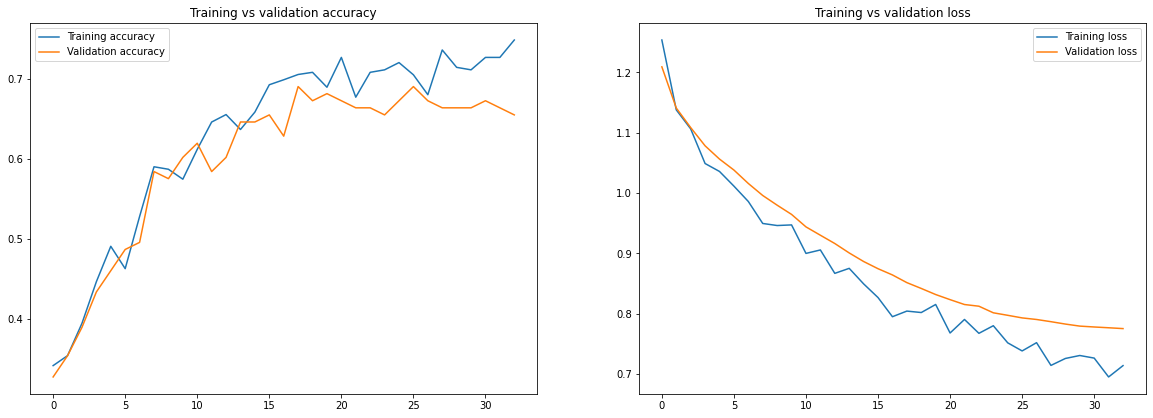

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H16_soft_pre_cate                            ##
pred_Dense = pred_H16_soft_pre_cate                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[15  4 16]
 [ 0 38  3]
 [ 8  8 21]]
Normalized confusion matrix
[[0.43 0.11 0.46]
 [0.   0.93 0.07]
 [0.22 0.22 0.57]]


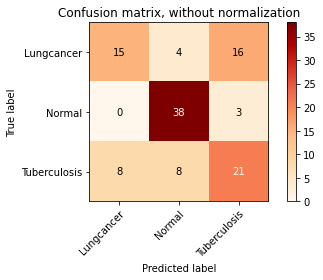

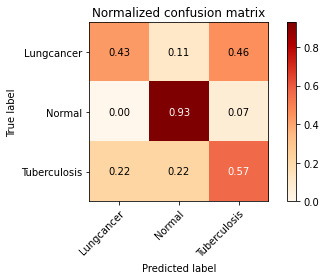

In [ ]:
y_pred = pred_H16_soft_pre_cate.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 soft pre cate adam
--> 0.59

In [ ]:
BS = 16                                                       ##
filepath = "model16_soft_pre_cate_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 98.06it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H16_soft_pre_cate_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H16_soft_pre_cate_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_cate_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)     

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 1.1200 - accuracy: 0.3478
Epoch 1: val_accuracy improved from -inf to 0.38938, saving model to model16_soft_pre_cate_adam.h5
21/21 [==============================] - 23s 539ms/step - loss: 1.1200 - accuracy: 0.3478 - val_loss: 1.1003 - val_accuracy: 0.3894 - lr: 1.0000e-04
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 1.0614 - accuracy: 0.4255
Epoch 2: val_accuracy did not improve from 0.38938
21/21 [==============================] - 6s 291ms/step - loss: 1.0614 - accuracy: 0.4255 - val_loss: 1.1016 - val_accuracy: 0.3894 - lr: 1.0000e-04
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 1.0614 - accuracy: 0.4627
Epoch 3: val_accuracy improved from 0.38938 to 0.41593, saving model to model16_soft_pre_cate_adam.h5
21/21 [==============================] - 8s 373ms/step - loss: 1.0614 - accuracy: 0.4627 - val_loss: 1.0682 - val_accuracy: 0.4159 - lr: 1.0000e-04
Epoch 4/100
21/21 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

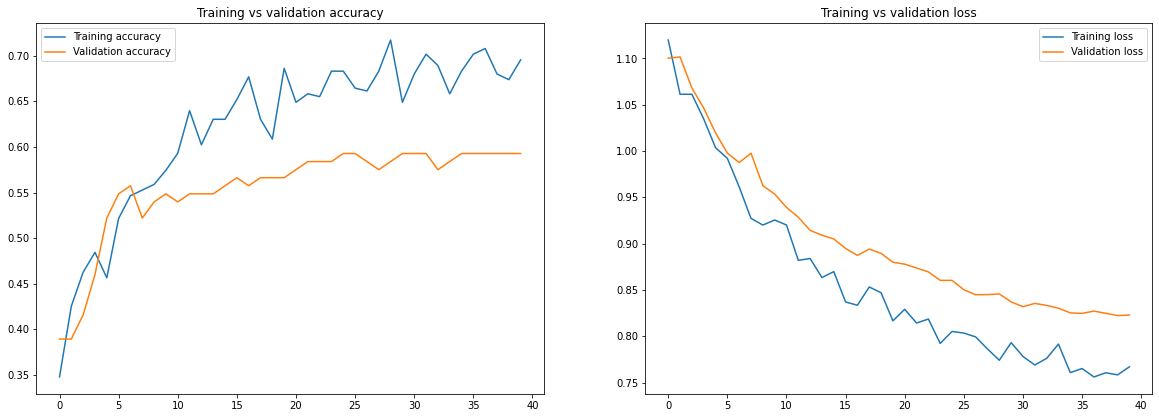

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H16_soft_pre_cate_adam                            ##
pred_Dense = pred_H16_soft_pre_cate_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[15 11  9]
 [ 0 41  0]
 [12 14 11]]
Normalized confusion matrix
[[0.43 0.31 0.26]
 [0.   1.   0.  ]
 [0.32 0.38 0.3 ]]


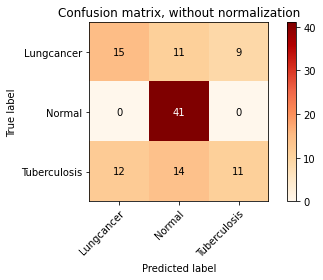

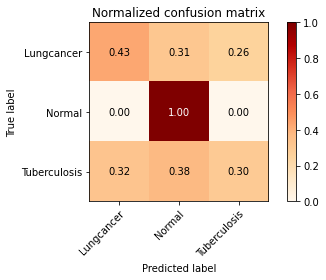

In [ ]:
y_pred = pred_H16_soft_pre_cate_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 32

#### 32  soft pre bi
--> 0.61

In [ ]:
BS = 32                                                       ##
filepath = "model32_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 95.14it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H32_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])

pred_H32_soft_pre_bi = model_Dense.predict(x_test_Dense)
    

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H32_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)       

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.6758 - accuracy: 0.3105
Epoch 1: val_accuracy improved from -inf to 0.33628, saving model to model32_soft_pre_bi.h5
10/10 [==============================] - 25s 1s/step - loss: 0.6758 - accuracy: 0.3105 - val_loss: 0.6601 - val_accuracy: 0.3363 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.6512 - accuracy: 0.3595
Epoch 2: val_accuracy did not improve from 0.33628
10/10 [==============================] - 6s 568ms/step - loss: 0.6512 - accuracy: 0.3595 - val_loss: 0.6495 - val_accuracy: 0.3097 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.6428 - accuracy: 0.3987
Epoch 3: val_accuracy did not improve from 0.33628
10/10 [==============================] - 6s 575ms/step - loss: 0.6428 - accuracy: 0.3987 - val_loss: 0.6429 - val_accuracy: 0.3009 - lr: 1.0000e-04
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.6355 - a

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

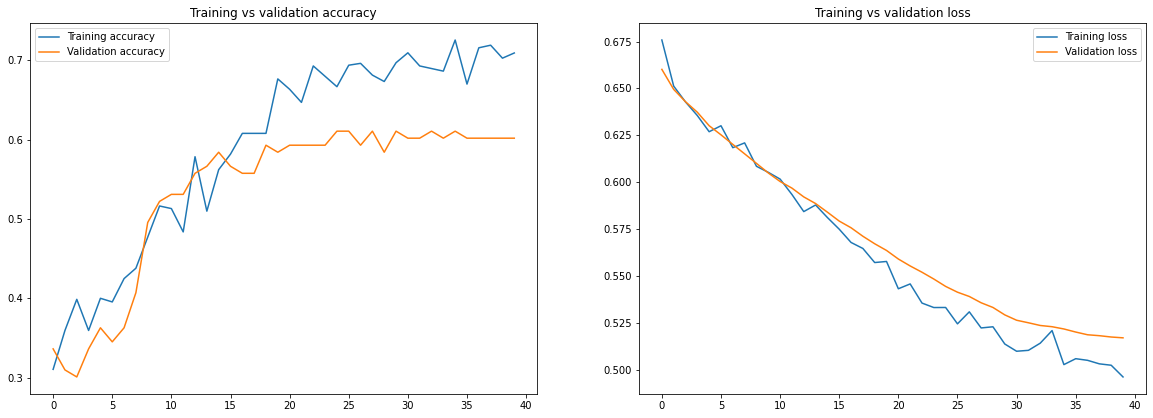

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H32_soft_pre_bi                            ##
pred_Dense = pred_H32_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[16  5 14]
 [ 0 40  1]
 [11 14 12]]
Normalized confusion matrix
[[0.46 0.14 0.4 ]
 [0.   0.98 0.02]
 [0.3  0.38 0.32]]


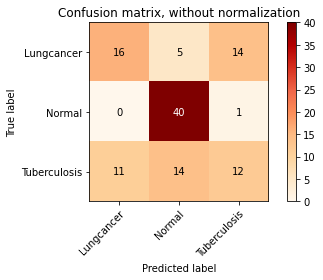

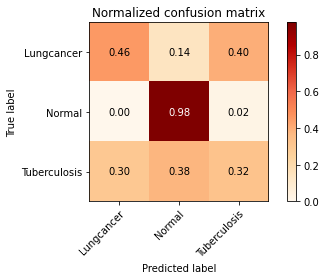

In [ ]:
y_pred = pred_H32_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft pre bi adam
--> 0.68

In [ ]:
BS = 32                                                      ##
filepath = "model32_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 95.83it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H32_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H32_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H32_soft_pre_bi_adam.argmax(axis=1),               ####
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.6847 - accuracy: 0.2908
Epoch 1: val_accuracy improved from -inf to 0.28319, saving model to model32_soft_pre_bi_adam.h5
10/10 [==============================] - 24s 1s/step - loss: 0.6847 - accuracy: 0.2908 - val_loss: 0.6634 - val_accuracy: 0.2832 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.6576 - accuracy: 0.2876
Epoch 2: val_accuracy did not improve from 0.28319
10/10 [==============================] - 6s 574ms/step - loss: 0.6576 - accuracy: 0.2876 - val_loss: 0.6502 - val_accuracy: 0.2832 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.6595 - accuracy: 0.3137
Epoch 3: val_accuracy improved from 0.28319 to 0.38938, saving model to model32_soft_pre_bi_adam.h5
10/10 [==============================] - 8s 764ms/step - loss: 0.6595 - accuracy: 0.3137 - val_loss: 0.6444 - val_accuracy: 0.3894 - lr: 1.0000e-04
Epoch 4/100
10/10 [======

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

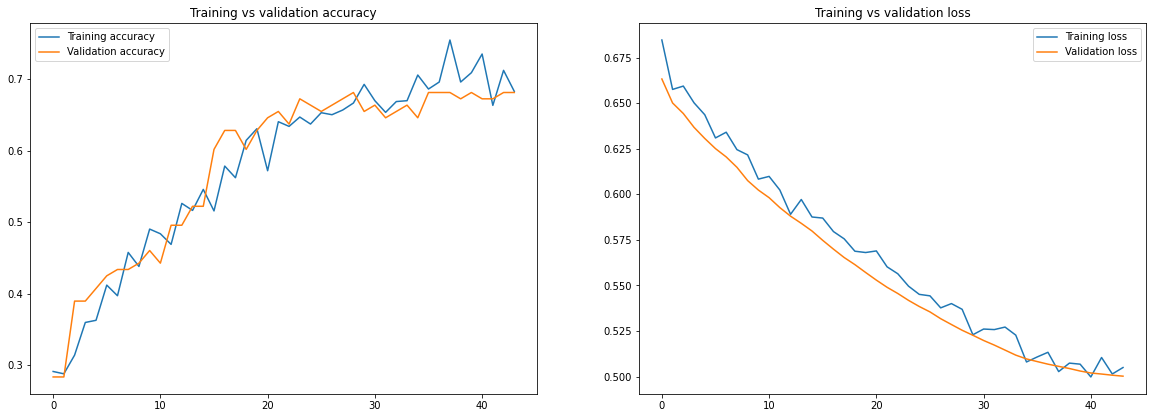

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H32_soft_pre_bi_adam                            ##
pred_Dense = pred_H32_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[19  5 11]
 [ 0 38  3]
 [10  7 20]]
Normalized confusion matrix
[[0.54 0.14 0.31]
 [0.   0.93 0.07]
 [0.27 0.19 0.54]]


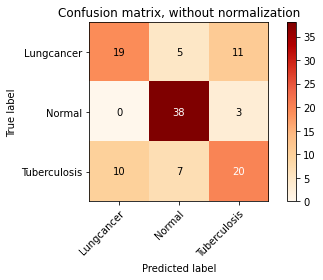

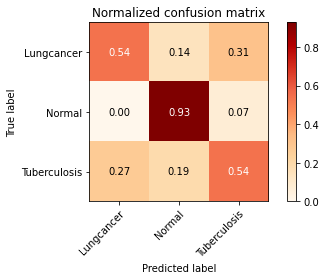

In [ ]:
y_pred = pred_H32_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft pre cate 
--> 0.65

In [ ]:
BS = 32                                                             ##
filepath = "model32_soft_pre_cate.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 91.96it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H32_soft_pre_cate = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H32_soft_pre_cate = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H32_soft_pre_cate.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 1.0790 - accuracy: 0.4085
Epoch 1: val_accuracy improved from -inf to 0.47788, saving model to model32_soft_pre_cate.h5
10/10 [==============================] - 23s 1s/step - loss: 1.0790 - accuracy: 0.4085 - val_loss: 1.0715 - val_accuracy: 0.4779 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 1.0534 - accuracy: 0.4673
Epoch 2: val_accuracy improved from 0.47788 to 0.49558, saving model to model32_soft_pre_cate.h5
10/10 [==============================] - 7s 748ms/step - loss: 1.0534 - accuracy: 0.4673 - val_loss: 1.0530 - val_accuracy: 0.4956 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 1.0647 - accuracy: 0.4346
Epoch 3: val_accuracy improved from 0.49558 to 0.51327, saving model to model32_soft_pre_cate.h5
10/10 [==============================] - 7s 760ms/step - loss: 1.0647 - accuracy: 0.4346 - val_loss: 1.0412 - val_accuracy: 0.5133 - 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

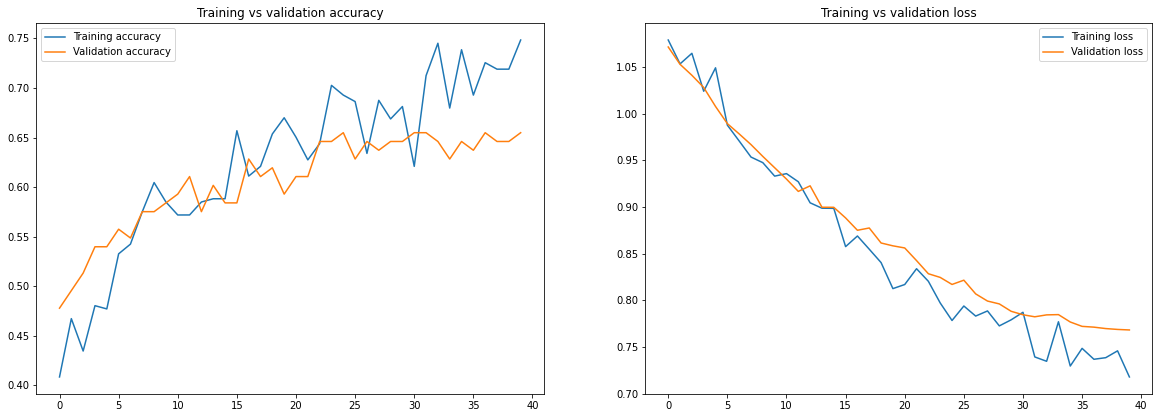

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H32_soft_pre_cate                            ##
pred_Dense = pred_H32_soft_pre_cate                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[22  5  8]
 [ 1 40  0]
 [14 11 12]]
Normalized confusion matrix
[[0.63 0.14 0.23]
 [0.02 0.98 0.  ]
 [0.38 0.3  0.32]]


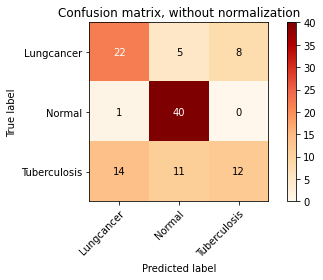

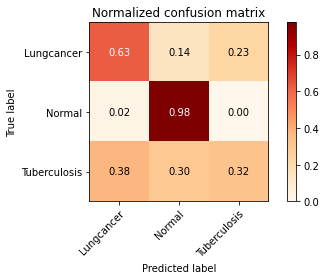

In [ ]:
y_pred = pred_H32_soft_pre_cate.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft pre cate adam
--> 0.60

In [ ]:
BS = 32                                                       ##
filepath = "model32_soft_pre_cate_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 95.28it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H32_soft_pre_cate_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense,  batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H32_soft_pre_cate_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H32_soft_pre_cate_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
from google.colab import files
files.download( filepath)        

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 1.4055 - accuracy: 0.3562
Epoch 1: val_accuracy improved from -inf to 0.33628, saving model to model32_soft_pre_cate_adam.h5
10/10 [==============================] - 23s 1s/step - loss: 1.4055 - accuracy: 0.3562 - val_loss: 1.4067 - val_accuracy: 0.3363 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 1.2666 - accuracy: 0.3235
Epoch 2: val_accuracy did not improve from 0.33628
10/10 [==============================] - 6s 573ms/step - loss: 1.2666 - accuracy: 0.3235 - val_loss: 1.3055 - val_accuracy: 0.2920 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 1.1661 - accuracy: 0.3464
Epoch 3: val_accuracy did not improve from 0.33628
10/10 [==============================] - 6s 577ms/step - loss: 1.1661 - accuracy: 0.3464 - val_loss: 1.2550 - val_accuracy: 0.2389 - lr: 1.0000e-04
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 1.1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

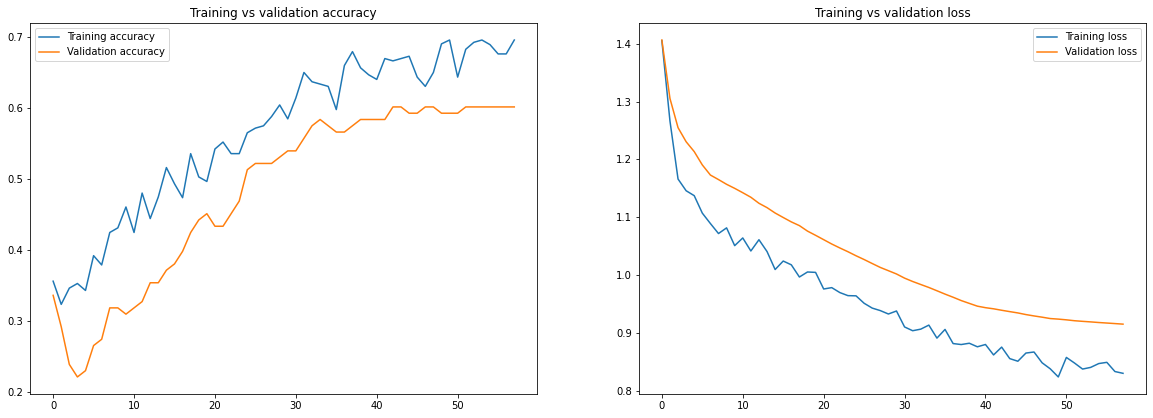

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H32_soft_pre_cate_adam                            ##
pred_Dense = pred_H32_soft_pre_cate_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[22  7  6]
 [ 2 35  4]
 [15 11 11]]
Normalized confusion matrix
[[0.63 0.2  0.17]
 [0.05 0.85 0.1 ]
 [0.41 0.3  0.3 ]]


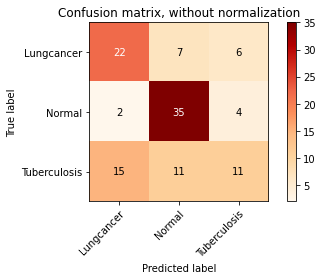

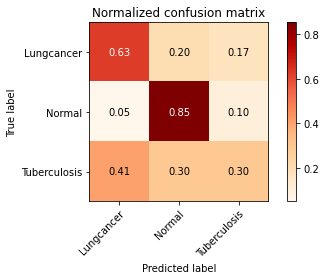

In [ ]:
y_pred = pred_H32_soft_pre_cate_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 1

#### 1  soft pre bi
--> 0.70

In [ ]:
BS = 1                                                      ##
filepath = "model1_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:07<00:00, 58.13it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H1_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
##
pred_H1_soft_pre_bi = model_Dense.predict(x_test_Dense)
    

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H1_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)       

Epoch 1/100
338/338 [==============================] - ETA: 0s - loss: 0.6711 - accuracy: 0.3669
Epoch 1: val_accuracy improved from -inf to 0.36283, saving model to model1_soft_pre_bi.h5
338/338 [==============================] - 92s 141ms/step - loss: 0.6711 - accuracy: 0.3669 - val_loss: 0.6356 - val_accuracy: 0.3628 - lr: 1.0000e-04
Epoch 2/100
338/338 [==============================] - ETA: 0s - loss: 0.6098 - accuracy: 0.5059
Epoch 2: val_accuracy improved from 0.36283 to 0.55752, saving model to model1_soft_pre_bi.h5
338/338 [==============================] - 25s 75ms/step - loss: 0.6098 - accuracy: 0.5059 - val_loss: 0.5909 - val_accuracy: 0.5575 - lr: 1.0000e-04
Epoch 3/100
338/338 [==============================] - ETA: 0s - loss: 0.5728 - accuracy: 0.5444
Epoch 3: val_accuracy did not improve from 0.55752
338/338 [==============================] - 24s 70ms/step - loss: 0.5728 - accuracy: 0.5444 - val_loss: 0.5651 - val_accuracy: 0.5398 - lr: 1.0000e-04
Epoch 4/100
338/338 [=

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

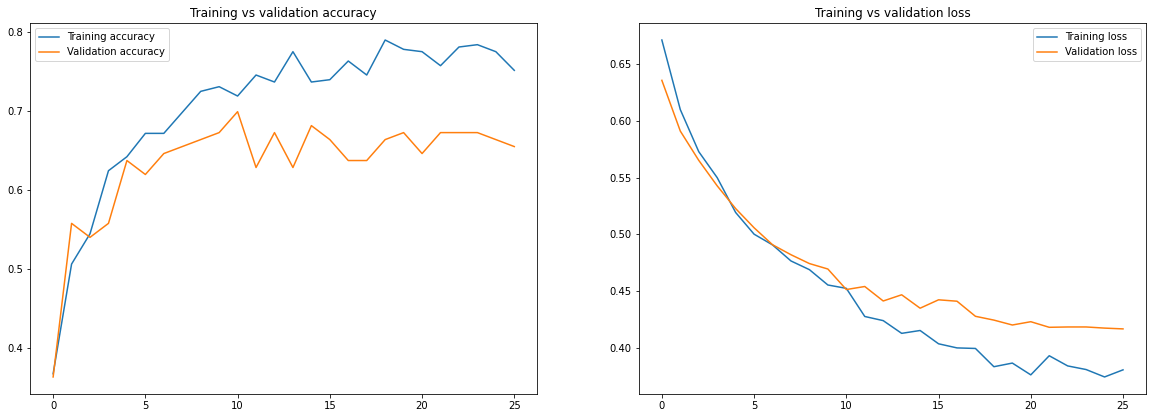

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H1_soft_pre_bi                            ##
pred_Dense = pred_H1_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[19  5 11]
 [ 0 39  2]
 [ 9 12 16]]
Normalized confusion matrix
[[0.54 0.14 0.31]
 [0.   0.95 0.05]
 [0.24 0.32 0.43]]


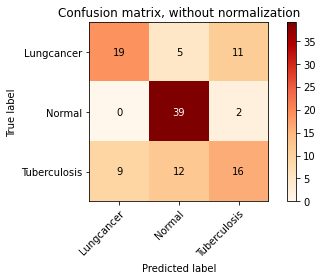

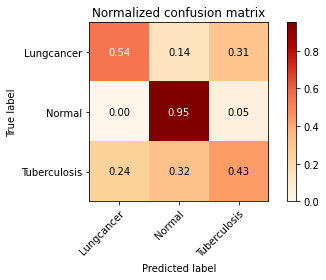

In [ ]:
y_pred = pred_H1_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 1 soft pre bi adam
--> 0.69

In [ ]:
BS = 1                                                            ##
filepath = "model1_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 95.18it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H1_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H1_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H1_soft_pre_bi_adam.argmax(axis=1),               ####
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
338/338 [==============================] - ETA: 0s - loss: 0.6332 - accuracy: 0.4142
Epoch 1: val_accuracy improved from -inf to 0.53097, saving model to model1_soft_pre_bi_adam.h5
338/338 [==============================] - 41s 86ms/step - loss: 0.6332 - accuracy: 0.4142 - val_loss: 0.5998 - val_accuracy: 0.5310 - lr: 1.0000e-04
Epoch 2/100
338/338 [==============================] - ETA: 0s - loss: 0.5782 - accuracy: 0.5680
Epoch 2: val_accuracy improved from 0.53097 to 0.61062, saving model to model1_soft_pre_bi_adam.h5
338/338 [==============================] - 25s 75ms/step - loss: 0.5782 - accuracy: 0.5680 - val_loss: 0.5667 - val_accuracy: 0.6106 - lr: 1.0000e-04
Epoch 3/100
338/338 [==============================] - ETA: 0s - loss: 0.5542 - accuracy: 0.5917
Epoch 3: val_accuracy did not improve from 0.61062
338/338 [==============================] - 24s 70ms/step - loss: 0.5542 - accuracy: 0.5917 - val_loss: 0.5406 - val_accuracy: 0.5841 - lr: 1.0000e-04
Epoch 4/100
3

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

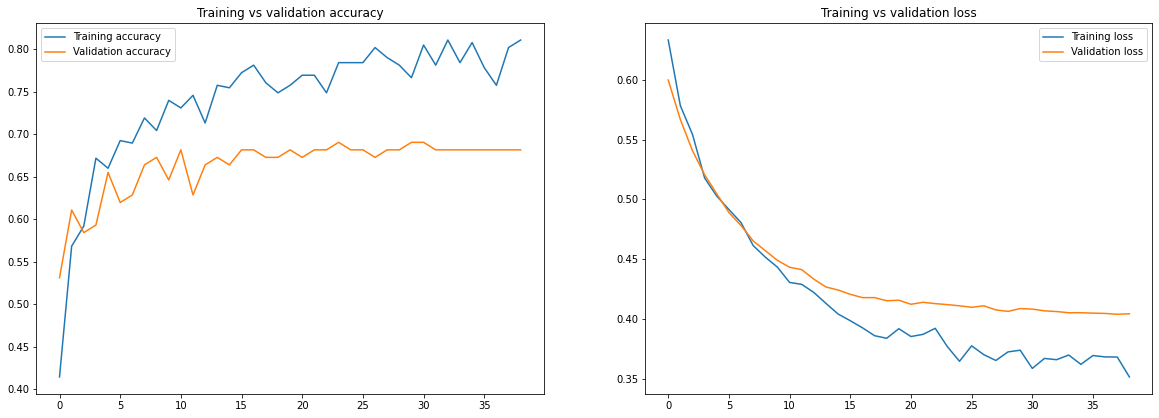

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H1_soft_pre_bi_adam                            ##
pred_Dense = pred_H1_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[20  4 11]
 [ 1 40  0]
 [11  9 17]]
Normalized confusion matrix
[[0.57 0.11 0.31]
 [0.02 0.98 0.  ]
 [0.3  0.24 0.46]]


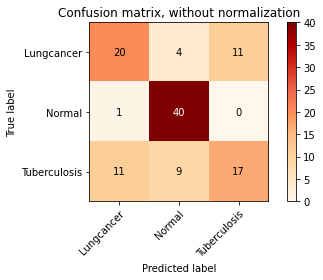

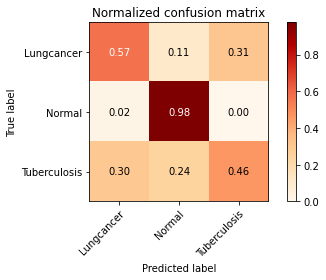

In [ ]:
y_pred = pred_H1_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 1 soft pre cate 
--> 0.70

In [ ]:
BS = 1                                                             ##
filepath = "mode1_soft_pre_cate.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 93.07it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H1_soft_pre_cate = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H1_soft_pre_cate = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H1_soft_pre_cate.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
338/338 [==============================] - ETA: 0s - loss: 1.2262 - accuracy: 0.2840
Epoch 1: val_accuracy improved from -inf to 0.33628, saving model to mode1_soft_pre_cate.h5
338/338 [==============================] - 41s 85ms/step - loss: 1.2262 - accuracy: 0.2840 - val_loss: 1.1604 - val_accuracy: 0.3363 - lr: 1.0000e-04
Epoch 2/100
338/338 [==============================] - ETA: 0s - loss: 1.0317 - accuracy: 0.4793
Epoch 2: val_accuracy improved from 0.33628 to 0.43363, saving model to mode1_soft_pre_cate.h5
338/338 [==============================] - 25s 75ms/step - loss: 1.0317 - accuracy: 0.4793 - val_loss: 1.0406 - val_accuracy: 0.4336 - lr: 1.0000e-04
Epoch 3/100
338/338 [==============================] - ETA: 0s - loss: 0.9610 - accuracy: 0.5414
Epoch 3: val_accuracy improved from 0.43363 to 0.51327, saving model to mode1_soft_pre_cate.h5
338/338 [==============================] - 25s 75ms/step - loss: 0.9610 - accuracy: 0.5414 - val_loss: 0.9611 - val_accuracy: 0

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

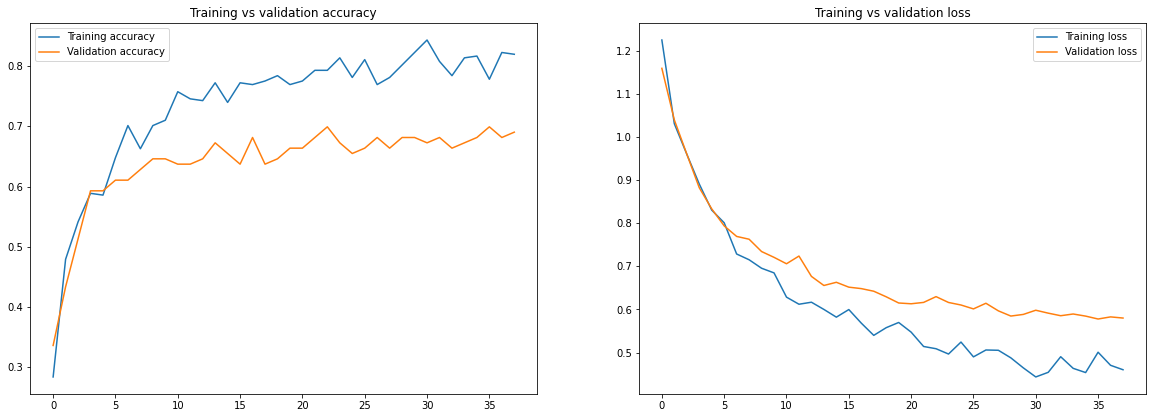

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H1_soft_pre_cate                            ##
pred_Dense = pred_H1_soft_pre_cate                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[20  3 12]
 [ 0 38  3]
 [11  6 20]]
Normalized confusion matrix
[[0.57 0.09 0.34]
 [0.   0.93 0.07]
 [0.3  0.16 0.54]]


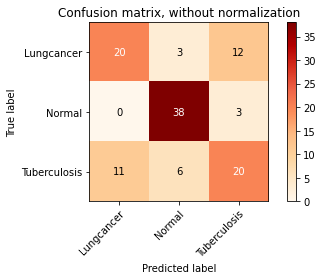

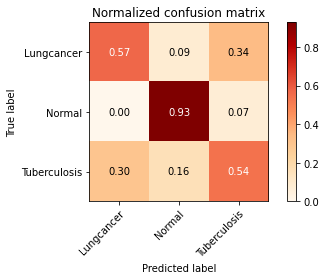

In [ ]:
y_pred = pred_H1_soft_pre_cate.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 1 soft pre cate adam
--> 0.72

In [ ]:
BS = 1                                                       ##
filepath = "model1_soft_pre_cate_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 93.98it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable=False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H1_soft_pre_cate_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H1_soft_pre_cate_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H1_soft_pre_cate_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
338/338 [==============================] - ETA: 0s - loss: 1.1877 - accuracy: 0.3580
Epoch 1: val_accuracy improved from -inf to 0.38053, saving model to model1_soft_pre_cate_adam.h5
338/338 [==============================] - 41s 84ms/step - loss: 1.1877 - accuracy: 0.3580 - val_loss: 1.1002 - val_accuracy: 0.3805 - lr: 1.0000e-04
Epoch 2/100
338/338 [==============================] - ETA: 0s - loss: 1.0191 - accuracy: 0.4675
Epoch 2: val_accuracy improved from 0.38053 to 0.46018, saving model to model1_soft_pre_cate_adam.h5
338/338 [==============================] - 25s 75ms/step - loss: 1.0191 - accuracy: 0.4675 - val_loss: 1.0114 - val_accuracy: 0.4602 - lr: 1.0000e-04
Epoch 3/100
338/338 [==============================] - ETA: 0s - loss: 0.9198 - accuracy: 0.5799
Epoch 3: val_accuracy improved from 0.46018 to 0.53097, saving model to model1_soft_pre_cate_adam.h5
338/338 [==============================] - 25s 75ms/step - loss: 0.9198 - accuracy: 0.5799 - val_loss: 0.9573

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

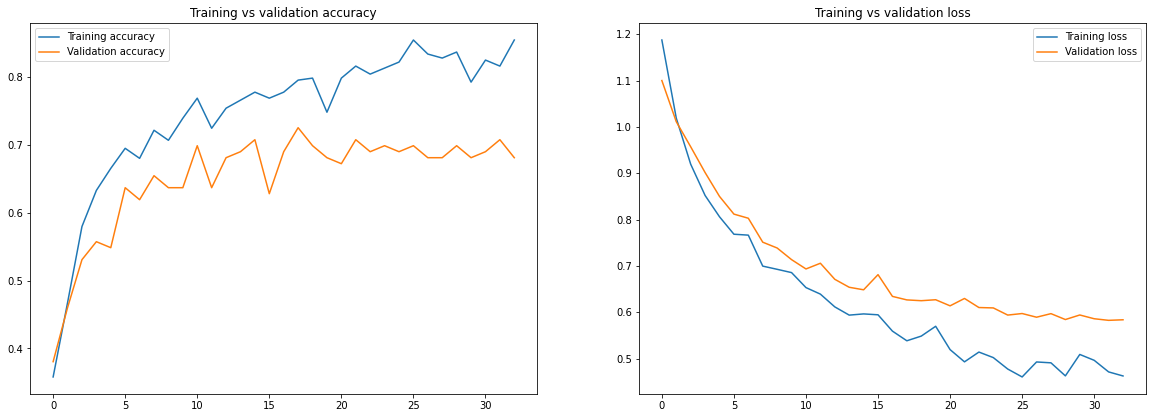

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H1_soft_pre_cate_adam                            ##
pred_Dense = pred_H1_soft_pre_cate_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[18  4 13]
 [ 0 38  3]
 [ 8  8 21]]
Normalized confusion matrix
[[0.51 0.11 0.37]
 [0.   0.93 0.07]
 [0.22 0.22 0.57]]


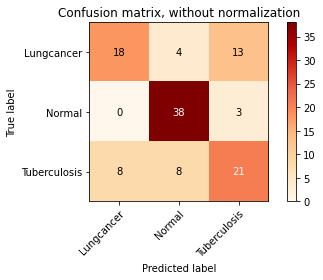

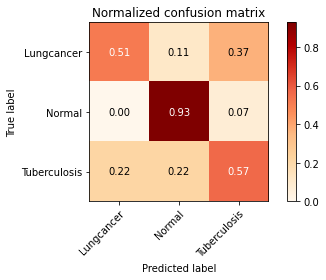

In [ ]:
y_pred = pred_H1_soft_pre_cate_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# InceptionV3

## 1) Find Tuning

### -->ACC = 0.90

*   BS = 32
*   activation="softmax"
*   fix weight & bias in layer 0-100
*   learning_rate=0.0001
*   epoch 15

##### Data

In [ ]:
train_img3_Incep = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (299, 299))                                       #ขนาดของ input
    train_img3_Incep.append(img)

data3_Incep = np.array(train_img3_Incep, dtype="float32") / 255.0

100%|██████████| 451/451 [01:58<00:00,  3.80it/s]


In [ ]:
labels3_Incep = np.array(data_train3[['NameType']] )        
labels3_Incep.shape = (len(labels3_Incep),) 

le3_Incep = LabelEncoder()                                                                     
labels3_Incep = le3_Incep.fit_transform(labels3_Incep)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels3_Incep = to_categorical(labels3_Incep, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

##### Model

In [ ]:
base_model3_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model3_Incep.layers)

87924736/87910968 [==============================] - 0s 0us/step


311

In [ ]:
base_model3_Incep.trainable = True
for layer in base_model3_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

In [ ]:
#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model3_Incep.output)

prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model3_IncepF = tf.keras.models.Model(inputs=base_model3_Incep.input, outputs=prediction_layer)

model3_IncepF.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
INIT_LR = 1e-1
BS = 32
EPOCHS = 50

aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
kf_IncepF = KFold(5, shuffle=True, random_state=40) 

oos_yF = []
oos_predF = []
fold = 0

for train, test in kf_IncepF.split(data3_Incep):
    fold+=1
    print(f"Fold #{fold}")
        
    xtrain_IncepF = data3_Incep[train]
    ytrain_IncepF = labels3_Incep[train]
    xtest_IncepF = data3_Incep[test]
    ytest_IncepF = labels3_Incep[test]

    M_IncepF = model3_IncepF.fit( x=aug.flow(xtrain_IncepF, ytrain_IncepF, batch_size=BS),
	                                            validation_data=(xtest_IncepF, ytest_IncepF),
	                                            steps_per_epoch=len(xtrain_IncepF) // BS,
	                                            epochs=15,  callbacks = [callback])
    
    pred_IncepF = model3_IncepF.predict(xtest_IncepF)
    
    oos_yF.append(ytest_IncepF)
    oos_predF.append(pred_IncepF)  
    print(classification_report(ytest_IncepF.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_IncepF.argmax(axis=1),  
                                        target_names=le3_Incep.classes_))

#   score = metrics.accuracy_score(ytest_IncepF.argmax(axis=1),	        #ค่า acc
#                                               pred_IncepF.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(ytest_IncepF.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_IncepF.argmax(axis=1) ) )

Fold #1
Epoch 1/15
11/11 [==============================] - 212s 18s/step - loss: 0.5453 - accuracy: 0.5701 - val_loss: 0.8733 - val_accuracy: 0.4396
Epoch 2/15
11/11 [==============================] - 188s 17s/step - loss: 0.3283 - accuracy: 0.7957 - val_loss: 0.8059 - val_accuracy: 0.4725
Epoch 3/15
11/11 [==============================] - 188s 17s/step - loss: 0.2771 - accuracy: 0.8476 - val_loss: 0.7430 - val_accuracy: 0.5604
Epoch 4/15
11/11 [==============================] - 188s 17s/step - loss: 0.1564 - accuracy: 0.9238 - val_loss: 0.7924 - val_accuracy: 0.5385
Epoch 5/15
11/11 [==============================] - 188s 17s/step - loss: 0.1670 - accuracy: 0.9207 - val_loss: 0.8088 - val_accuracy: 0.5714
Epoch 6/15
11/11 [==============================] - 188s 17s/step - loss: 0.1128 - accuracy: 0.9421 - val_loss: 0.8733 - val_accuracy: 0.5714
Epoch 7/15
11/11 [==============================] - 188s 18s/step - loss: 0.1176 - accuracy: 0.9299 - val_loss: 1.0824 - val_accuracy: 0.527

In [ ]:
oos_yF = np.concatenate(oos_yF)
oos_predF = np.concatenate(oos_predF)

In [ ]:
score = metrics.accuracy_score(oos_yF.argmax(axis=1),	        #ค่า acc
                                             oos_predF.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_yF.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_predF.argmax(axis=1),  
                                        target_names=le3_Incep.classes_))

Fold score (accuracy): 0.9046563192904656
              precision    recall  f1-score   support

  Lungcancer       1.00      0.82      0.90       150
      Normal       0.99      0.90      0.94       151
Tuberculosis       0.78      0.99      0.88       150

    accuracy                           0.90       451
   macro avg       0.92      0.90      0.91       451
weighted avg       0.92      0.90      0.91       451



In [ ]:
#ลองเซฟโมเดล
fold = 2
if metrics.accuracy_score( ytest_IncepF.argmax(axis=1),  pred_IncepF.argmax(axis=1) )>0.7:
    name = (f' model3_IncepF{fold}')
    joblib.dump(model3_IncepF, name)

INFO:tensorflow:Assets written to: ram://a5d1d51e-3da4-454e-81fb-752e887bd981/assets


## 2) Find Tuning  

###--> ACC = 0.76  
###--> ใช้เวลา 8173.251 วินาที = 136.22 นาที = 2.27 ชั่วโมง

*   BS = 16
*   activation="softmax"
*   fix weight & bias in layer 0-100
*   learning_rate=0.0001
*   epoch 30


##### Data

In [ ]:
train_img3_Incep = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (299, 299))                                       #ขนาดของ input
    train_img3_Incep.append(img)

data3_Incep = np.array(train_img3_Incep, dtype="float32") / 255.0

100%|██████████| 451/451 [03:31<00:00,  2.13it/s]


In [ ]:
labels3_Incep = np.array(data_train3[['NameType']] )        
labels3_Incep.shape = (len(labels3_Incep),) 

le3_Incep = LabelEncoder()                                                                     
labels3_Incep = le3_Incep.fit_transform(labels3_Incep)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels3_Incep = to_categorical(labels3_Incep, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

##### Model

In [ ]:
base_model3_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model3_Incep.layers)

87924736/87910968 [==============================] - 1s 0us/step


311

In [ ]:
base_model3_Incep.trainable = True
for layer in base_model3_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

In [ ]:
#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model3_Incep.output)

prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model3_IncepF2 = tf.keras.models.Model(inputs=base_model3_Incep.input, outputs=prediction_layer)

model3_IncepF2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
INIT_LR = 1e-1
BS = 16
EPOCHS = 50

aug2 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.15,				  #เลื่อนลง-ขึ้น ซ้ายขวา
		height_shift_range=0.15,
		shear_range=0.15, 						#ขยับมุมภาพ ซ้าย และ/หรือ ขวา ไปด้านข้าง เช่น จะกลายเป็นสี่เหลี่ยมด้านขนาน 
		horizontal_flip=True,
		fill_mode='constant')

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
kf_IncepF2 = KFold(5, shuffle=True, random_state=40) 

oos_yF2 = []
oos_predF2 = []
fold = 0

for train, test in kf_IncepF2.split(data3_Incep):
    fold+=1
    print(f"Fold #{fold}")
        
    xtrain_IncepF2 = data3_Incep[train]
    ytrain_IncepF2 = labels3_Incep[train]
    xtest_IncepF2 = data3_Incep[test]
    ytest_IncepF2 = labels3_Incep[test]

    M_IncepF2 = model3_IncepF2.fit( x=aug2.flow(xtrain_IncepF2, ytrain_IncepF2, batch_size=BS),
	                                            validation_data=(xtest_IncepF2, ytest_IncepF2),
	                                            steps_per_epoch=len(xtrain_IncepF2) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_IncepF2 = model3_IncepF2.predict(xtest_IncepF2)

    oos_yF2.append(ytest_IncepF2)
    oos_predF2.append(pred_IncepF2) 

    score = metrics.accuracy_score(ytest_IncepF2.argmax(axis=1),	        #ค่า acc
                                               pred_IncepF2.argmax(axis=1) )
    print(f'Fold #{fold} score (accuracy): {score}')
    

#    if metrics.accuracy_score( ytest_IncepF2.argmax(axis=1),  pred_IncepF2.argmax(axis=1) )>0.9:
 #       name = (f' model3_IncepF2_Fold{fold}')
  #      joblib.dump(model3_IncepF2, name)

#    print(confusion_matrix(ytest_IncepF.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_IncepF.argmax(axis=1) ) )

Fold #1
Epoch 1/30
22/22 [==============================] - 187s 8s/step - loss: 0.4612 - accuracy: 0.6686 - val_loss: 1.4591 - val_accuracy: 0.3736
Epoch 2/30
22/22 [==============================] - 175s 8s/step - loss: 0.3046 - accuracy: 0.8052 - val_loss: 1.3021 - val_accuracy: 0.4396
Epoch 3/30
22/22 [==============================] - 173s 8s/step - loss: 0.2600 - accuracy: 0.8314 - val_loss: 1.0278 - val_accuracy: 0.5055
Epoch 4/30
22/22 [==============================] - 174s 8s/step - loss: 0.2032 - accuracy: 0.8634 - val_loss: 1.0180 - val_accuracy: 0.5714
Epoch 5/30
22/22 [==============================] - 174s 8s/step - loss: 0.1327 - accuracy: 0.9331 - val_loss: 1.1071 - val_accuracy: 0.6044
Epoch 6/30
22/22 [==============================] - 174s 8s/step - loss: 0.1238 - accuracy: 0.9331 - val_loss: 0.7453 - val_accuracy: 0.6813
Epoch 7/30
22/22 [==============================] - 174s 8s/step - loss: 0.1349 - accuracy: 0.9390 - val_loss: 0.4770 - val_accuracy: 0.7692
Epoch

In [ ]:
oos_yF2 = np.concatenate(oos_yF2)
oos_predF2 = np.concatenate(oos_predF2)

In [ ]:
print(classification_report(oos_yF2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_predF2.argmax(axis=1),  
                                        target_names=le3_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.99      0.59      0.74       150
      Normal       0.93      0.72      0.81       151
Tuberculosis       0.60      0.98      0.74       150

    accuracy                           0.76       451
   macro avg       0.84      0.76      0.76       451
weighted avg       0.84      0.76      0.76       451



## 3) Find Tuning 
###--> ACC = 81
###--> 5815.668 วินาที

*   BS = 8
*   activation="softmax"
*   fix weight & bias in layer 0-100
*   learning_rate=0.0001
*   epoch 30







In [ ]:
train_img3_Incep = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (299, 299))                                       #ขนาดของ input
    train_img3_Incep.append(img)

data3_Incep = np.array(train_img3_Incep, dtype="float32") / 255.0

100%|██████████| 451/451 [00:05<00:00, 83.92it/s] 


In [ ]:
labels3_Incep = np.array(data_train3[['NameType']] )        
labels3_Incep.shape = (len(labels3_Incep),) 

le3_Incep = LabelEncoder()                                                                     
labels3_Incep = le3_Incep.fit_transform(labels3_Incep)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels3_Incep = to_categorical(labels3_Incep, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

##### Model

In [ ]:
base_model3_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model3_Incep.layers)

311

In [ ]:
base_model3_Incep.trainable = True
for layer in base_model3_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

In [ ]:
#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model3_Incep.output)

prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model3_IncepF3 = tf.keras.models.Model(inputs=base_model3_Incep.input, outputs=prediction_layer)

model3_IncepF3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
INIT_LR = 1e-1
BS = 8

aug3 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
kf_IncepF3 = KFold(5, shuffle=True, random_state=40) 

oos_yF3 = []
oos_predF3 = []
fold = 0

for train, test in kf_IncepF3.split(data3_Incep):
    fold+=1
    print(f"Fold #{fold}")
        
    xtrain_IncepF3 = data3_Incep[train]
    ytrain_IncepF3 = labels3_Incep[train]
    xtest_IncepF3 = data3_Incep[test]
    ytest_IncepF3 = labels3_Incep[test]

    M_IncepF3 = model3_IncepF3.fit( x=aug3.flow(xtrain_IncepF3, ytrain_IncepF3, batch_size=BS),
	                                            validation_data=(xtest_IncepF3, ytest_IncepF3),
	                                            steps_per_epoch=len(xtrain_IncepF3) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_IncepF3 = model3_IncepF3.predict(xtest_IncepF3)
    
    oos_yF3.append(ytest_IncepF3)
    oos_predF3.append(pred_IncepF3)  
    print(classification_report(ytest_IncepF3.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_IncepF3.argmax(axis=1),  
                                        target_names=le3_Incep.classes_))

#   score = metrics.accuracy_score(ytest_IncepF.argmax(axis=1),	        #ค่า acc
#                                               pred_IncepF.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(ytest_IncepF.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_IncepF.argmax(axis=1) ) )

Fold #1
Epoch 1/30
45/45 [==============================] - 195s 4s/step - loss: 0.4942 - accuracy: 0.6361 - val_loss: 0.7942 - val_accuracy: 0.4286
Epoch 2/30
45/45 [==============================] - 183s 4s/step - loss: 0.3243 - accuracy: 0.8000 - val_loss: 1.0859 - val_accuracy: 0.4835
Epoch 3/30
45/45 [==============================] - 183s 4s/step - loss: 0.2680 - accuracy: 0.8333 - val_loss: 1.0556 - val_accuracy: 0.5275
Epoch 4/30
45/45 [==============================] - 183s 4s/step - loss: 0.2613 - accuracy: 0.8694 - val_loss: 0.3897 - val_accuracy: 0.8022
Epoch 5/30
45/45 [==============================] - 183s 4s/step - loss: 0.2072 - accuracy: 0.8944 - val_loss: 0.8960 - val_accuracy: 0.6044
Epoch 6/30
45/45 [==============================] - 183s 4s/step - loss: 0.1478 - accuracy: 0.9083 - val_loss: 0.5644 - val_accuracy: 0.7692
Epoch 7/30
45/45 [==============================] - 188s 4s/step - loss: 0.1602 - accuracy: 0.9250 - val_loss: 1.2475 - val_accuracy: 0.6813
     

In [ ]:
oos_yF3 = np.concatenate(oos_yF3)
oos_predF3 = np.concatenate(oos_predF3)

In [ ]:
print(classification_report(oos_yF3.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_predF3.argmax(axis=1),  
                                        target_names=le3_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       1.00      0.54      0.70       150
      Normal       0.94      0.91      0.93       151
Tuberculosis       0.66      0.98      0.79       150

    accuracy                           0.81       451
   macro avg       0.87      0.81      0.81       451
weighted avg       0.87      0.81      0.81       451



## 3.1) Find Tuning  

###--> ACC = 0.72
###--> ใช้เวลา 6354.25  วินาที 

*   BS = 8
*   activation="sigmoid"
*   fix weight & bias in layer 0-100
*   learning_rate=0.0001
*   epoch 30


##### Data

In [ ]:
train_img3_Incep = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (299, 299))                                       #ขนาดของ input
    train_img3_Incep.append(img)

data3_Incep = np.array(train_img3_Incep, dtype="float32") / 255.0

100%|██████████| 451/451 [00:05<00:00, 86.56it/s] 


In [ ]:
labels3_Incep = np.array(data_train3[['NameType']] )        
labels3_Incep.shape = (len(labels3_Incep),) 

le3_Incep = LabelEncoder()                                                                     
labels3_Incep = le3_Incep.fit_transform(labels3_Incep)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels3_Incep = to_categorical(labels3_Incep, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

##### Model

In [ ]:
base_model3_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model3_Incep.layers)

311

In [ ]:
base_model3_Incep.trainable = True
for layer in base_model3_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

In [ ]:
#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model3_Incep.output)

prediction_layer = tf.keras.layers.Dense(units=3, activation="sigmoid")(average_pooling_layer)   # unit 3
model3_IncepF31 = tf.keras.models.Model(inputs=base_model3_Incep.input, outputs=prediction_layer)

model3_IncepF31.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
INIT_LR = 1e-1
BS = 8

aug31 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
kf_IncepF31 = KFold(5, shuffle=True, random_state=40) 

oos_yF31 = []
oos_predF31 = []
fold = 0

for train, test in kf_IncepF31.split(data3_Incep):
    fold+=1
    print(f"Fold #{fold}")
        
    xtrain_IncepF31 = data3_Incep[train]
    ytrain_IncepF31 = labels3_Incep[train]
    xtest_IncepF31 = data3_Incep[test]
    ytest_IncepF31 = labels3_Incep[test]

    M_IncepF31 = model3_IncepF31.fit( x=aug31.flow(xtrain_IncepF31, ytrain_IncepF31, batch_size=BS),
	                                            validation_data=(xtest_IncepF31, ytest_IncepF31),
	                                            steps_per_epoch=len(xtrain_IncepF31) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_IncepF31 = model3_IncepF31.predict(xtest_IncepF31)
    
    oos_yF31.append(ytest_IncepF31)
    oos_predF31.append(pred_IncepF31)  
    print(classification_report(ytest_IncepF31.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_IncepF31.argmax(axis=1),  
                                        target_names=le3_Incep.classes_))

#   score = metrics.accuracy_score(ytest_IncepF.argmax(axis=1),	        #ค่า acc
#                                               pred_IncepF.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(ytest_IncepF.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_IncepF.argmax(axis=1) ) )

Fold #1
Epoch 1/30
45/45 [==============================] - 207s 4s/step - loss: 0.4663 - accuracy: 0.6417 - val_loss: 0.7496 - val_accuracy: 0.4725
Epoch 2/30
45/45 [==============================] - 188s 4s/step - loss: 0.3244 - accuracy: 0.7944 - val_loss: 0.5518 - val_accuracy: 0.5934
Epoch 3/30
45/45 [==============================] - 186s 4s/step - loss: 0.2740 - accuracy: 0.8250 - val_loss: 0.5254 - val_accuracy: 0.7033
Epoch 4/30
45/45 [==============================] - 187s 4s/step - loss: 0.1984 - accuracy: 0.8917 - val_loss: 0.3224 - val_accuracy: 0.8022
Epoch 5/30
45/45 [==============================] - 191s 4s/step - loss: 0.1850 - accuracy: 0.9056 - val_loss: 0.5997 - val_accuracy: 0.7253
Epoch 6/30
45/45 [==============================] - 191s 4s/step - loss: 0.1834 - accuracy: 0.8972 - val_loss: 0.7332 - val_accuracy: 0.6813
Epoch 7/30
45/45 [==============================] - 190s 4s/step - loss: 0.1598 - accuracy: 0.8944 - val_loss: 0.6397 - val_accuracy: 0.7802
     

In [ ]:
oos_yF31 = np.concatenate(oos_yF31)
oos_predF31 = np.concatenate(oos_predF31)

In [ ]:
print(classification_report(oos_yF31.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_predF31.argmax(axis=1),  
                                        target_names=le3_Incep.classes_))

## 4) Find Tuning 
###--> ACC =  76
###--> ใช้เวลา 4447.95 วินาที
*   BS = 1
*   activation="softmax"
*   fix weight & bias in layer 0-100
*   learning_rate=0.0001
*   epoch 30







In [ ]:
train_img3_Incep = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (299, 299))                                       #ขนาดของ input
    train_img3_Incep.append(img)

data3_Incep = np.array(train_img3_Incep, dtype="float32") / 255.0

100%|██████████| 451/451 [00:05<00:00, 86.58it/s] 


In [ ]:
labels3_Incep = np.array(data_train3[['NameType']] )        
labels3_Incep.shape = (len(labels3_Incep),) 

le3_Incep = LabelEncoder()                                                                     
labels3_Incep = le3_Incep.fit_transform(labels3_Incep)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels3_Incep = to_categorical(labels3_Incep, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

##### Model

In [ ]:
base_model3_Incep = tf.keras.applications.InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")
len(base_model3_Incep.layers)

311

In [ ]:
base_model3_Incep.trainable = True
for layer in base_model3_Incep.layers[:100]:    #fix w & bias in layer 0-100
    layer.trainable = False

In [ ]:
#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model3_Incep.output)

prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model3_IncepF4 = tf.keras.models.Model(inputs=base_model3_Incep.input, outputs=prediction_layer)

model3_IncepF4.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
INIT_LR = 1e-1
BS = 1

aug4 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
kf_IncepF4 = KFold(5, shuffle=True, random_state=40) 

oos_yF4 = []
oos_predF4 = []
fold = 0

for train, test in kf_IncepF4.split(data3_Incep):
    fold+=1
    print(f"Fold #{fold}")
        
    xtrain_IncepF4 = data3_Incep[train]
    ytrain_IncepF4 = labels3_Incep[train]
    xtest_IncepF4 = data3_Incep[test]
    ytest_IncepF4 = labels3_Incep[test]

    M_IncepF4 = model3_IncepF4.fit( x=aug4.flow(xtrain_IncepF4, ytrain_IncepF4, batch_size=BS),
	                                            validation_data=(xtest_IncepF4, ytest_IncepF4),
	                                            steps_per_epoch=len(xtrain_IncepF4) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_IncepF4 = model3_IncepF4.predict(xtest_IncepF4)
    
    oos_yF4.append(ytest_IncepF4)
    oos_predF4.append(pred_IncepF4)  
    print(classification_report(ytest_IncepF4.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_IncepF4.argmax(axis=1),  
                                        target_names=le3_Incep.classes_))

#   score = metrics.accuracy_score(ytest_IncepF.argmax(axis=1),	        #ค่า acc
#                                               pred_IncepF.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(ytest_IncepF.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_IncepF.argmax(axis=1) ) )

Fold #1
Epoch 1/30
360/360 [==============================] - 249s 665ms/step - loss: 0.5995 - accuracy: 0.4694 - val_loss: 0.8508 - val_accuracy: 0.5714
Epoch 2/30
360/360 [==============================] - 240s 666ms/step - loss: 0.4782 - accuracy: 0.5861 - val_loss: 0.5635 - val_accuracy: 0.6044
Epoch 3/30
360/360 [==============================] - 238s 661ms/step - loss: 0.4199 - accuracy: 0.6667 - val_loss: 0.6837 - val_accuracy: 0.6484
Epoch 4/30
360/360 [==============================] - 239s 663ms/step - loss: 0.3905 - accuracy: 0.6917 - val_loss: 0.6726 - val_accuracy: 0.7033
Epoch 5/30
360/360 [==============================] - 289s 802ms/step - loss: 0.3414 - accuracy: 0.7472 - val_loss: 0.4193 - val_accuracy: 0.7033
Epoch 6/30
360/360 [==============================] - 239s 663ms/step - loss: 0.3496 - accuracy: 0.7667 - val_loss: 0.4928 - val_accuracy: 0.7033
Epoch 7/30
360/360 [==============================] - 237s 658ms/step - loss: 0.2890 - accuracy: 0.8333 - val_loss: 

In [ ]:
oos_yF4 = np.concatenate(oos_yF4)
oos_predF4 = np.concatenate(oos_predF4)

In [ ]:
print(classification_report(oos_yF4.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_predF4.argmax(axis=1),  
                                        target_names=le3_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.83      0.70      0.76       150
      Normal       0.88      0.79      0.83       151
Tuberculosis       0.63      0.79      0.70       150

    accuracy                           0.76       451
   macro avg       0.78      0.76      0.76       451
weighted avg       0.78      0.76      0.76       451

